# Notes

# Imports

In [1]:
%%time
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from lmfit import minimize, Parameter, Parameters, report_fit
from IPython import display
#from progressbar import progressbar
#from numba import jit


CPU times: total: 1.2 s
Wall time: 1.2 s


# Model diagram

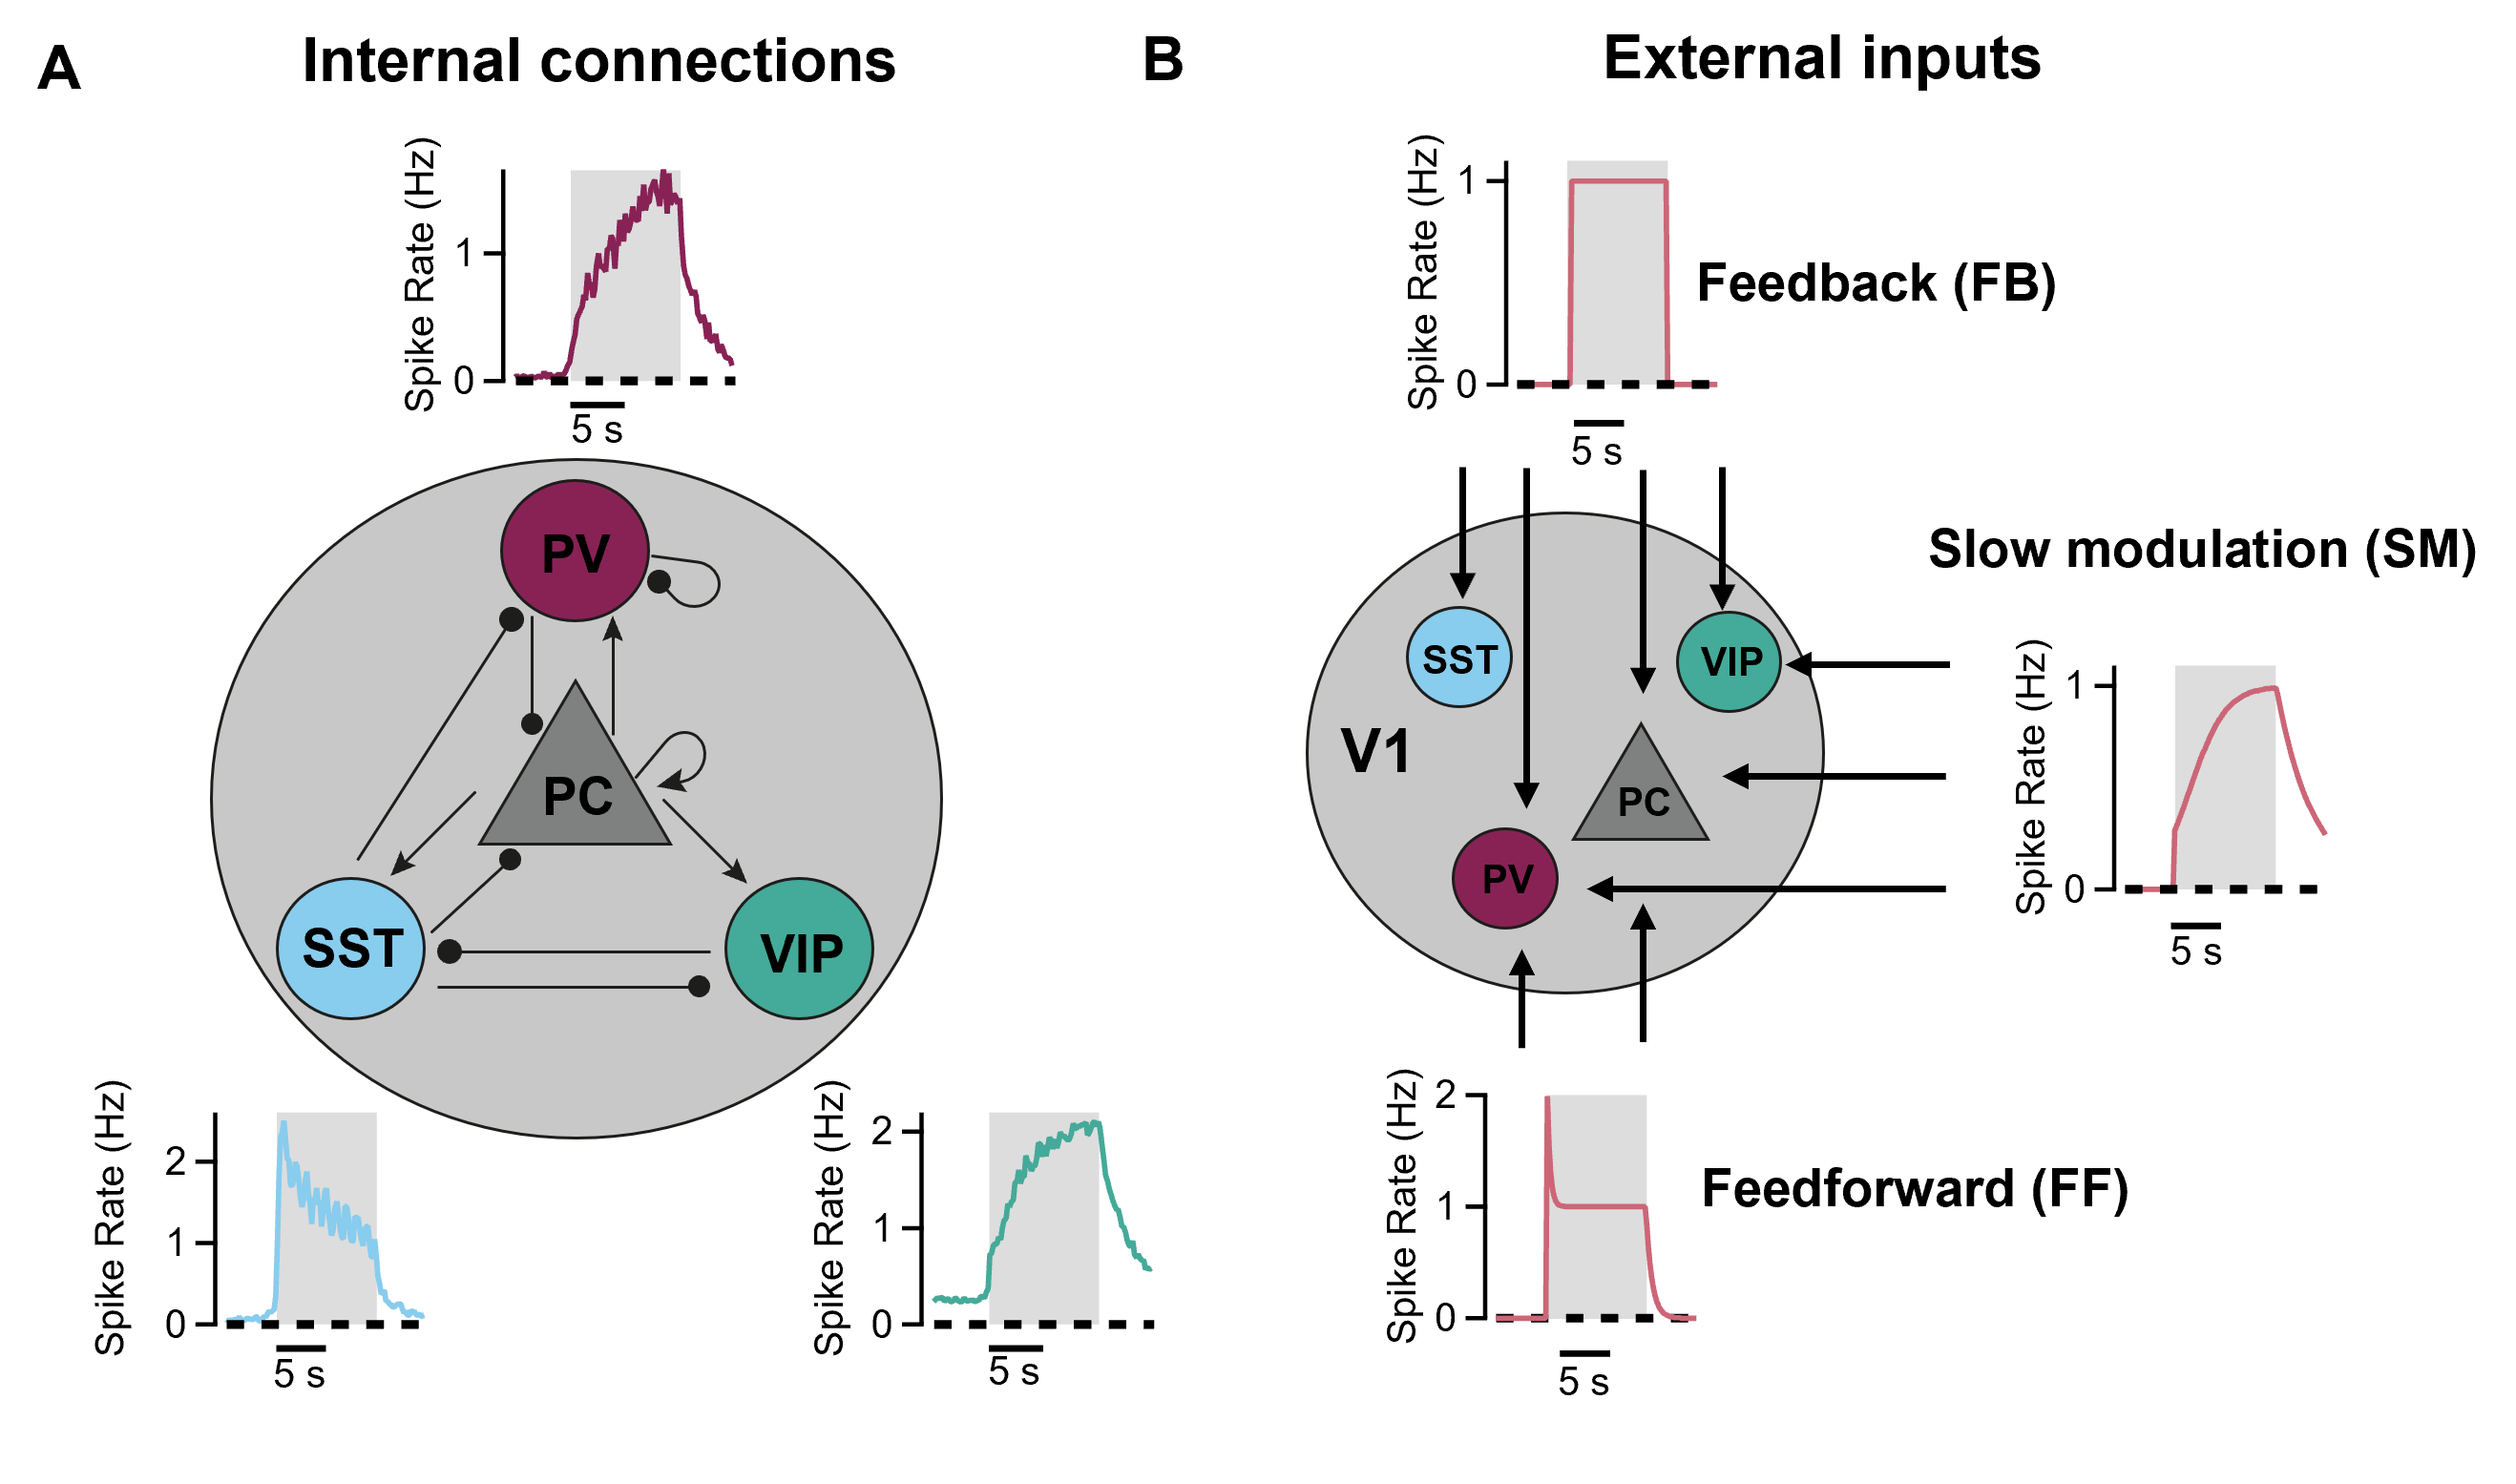

In [2]:
display.Image(r'Model_diagram.png')

# Functions

In [3]:
def Step(t, stim = 5, inter = 10, amp = 1.0, base = 0, k = 0, delay = 0, decay_f = 0):
    """
    Feedback (FB) input:
    ------------------------------------
    Represented as a step function. Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)             - time in seconds;
    stim (fixed) = 5 s      - time of the stimulus start;
    inter (fixed) = 10 s    - duration of the stimulus;
    amp (fixed) = 1.0 Hz    - amplitude of response;
    base (fixed) = 0 Hz     - baseline activity;
    k (fixed) = 0           - slope of the slow component. Used to be varied while testing linear depression or sensitization component in the FB input;
    delay (variable)        - delay of the FB input to the cell relative to the stimulus start;

    """
    
    if (t < stim + delay):
        h = base
    elif (t > stim + inter):
        h = amp * np.exp(-(t - stim - inter)*decay_f)
    else:
        h = amp*(t - stim - delay)*k*0.164745 + amp
    
    return h

In [4]:
def Sigm(t, stim = 5, inter = 10, ampl = 1.0, base = 0, rate = 1, delay = 0, decay_s = 1):
    """
    Slow modulation (SM) input:
    ------------------------------------
    Represented as a sigmoid function. Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    stim (fixed) = 5 s        - time of the stimulus start;
    inter (fixed) = 10 s      - duration of the stimulus;
    ampl (fixed) = 1.0 Hz     - amplitude of response;
    base (fixed) = 0 Hz       - baseline activity;
    rate (variable)           - time-constant of the SM input;
    delay (variable)          - shift of the sigmoid center relative to stimulus start;
    decay_s (varaible)        - time-constant of the SM input exponential decay after the end of stimulation;

    """
    
    if (t < stim):
        h = base
    elif (t > stim + inter):
        h = (base + (ampl/(1 + np.exp((delay-inter - dt)/rate))))*np.exp(-(t - stim - inter)*decay_s) + base
    
    else:
        h = base + (ampl/(1 + np.exp((stim + delay - t)/rate))) #Actualy rate here is time constant, where 1/rate is actual rate
        
    
    return h

In [5]:
def expon(t, stim = 5, inter = 10, ampl = 1.5, base = 0, decay = 1, delay = 0, b = 0, decay_ff = 0, s_start = 0.1, k = 0.1):
    """
    Feedforward (FF) input:
    ------------------------------------
    Represented as a flat step function with fast exponential decay on the stimulus start and linear increase during 10 second period. 
    Returns value of the input function in a time point t.
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    stim (fixed) = 5 s        - time of the stimulus start;
    inter (fixed) = 10 s      - duration of the stimulus;
    ampl (variable)           - amplitude of peak;
    base (fixed) = 1 Hz       - steady-state firing rate after fast exponential depression;
    decay (variable)          - time-constant of the fast exponential depression;
    delay (variable)          - delay of the FF input to the cell relative to the stimulus start;
    b (fixed) = 0 Hz          - baseline activity;
    decay_ff (varaible)       - time-constant of the FF input exponential decay after the end of stimulation;
    s_start (varaible)        - delay after stimulus when linear modulation starts;
    k (varaible)              - slope of the slow linear modulation;

    """
    
    if (t < stim + delay):
        h = b
    elif (t > stim + inter):
        h = (b + base + ampl*np.exp(-(inter-delay)*decay)+ (inter - delay - s_start)*k)*np.exp(-(t - stim - inter)*decay_ff)
    elif ((t >= stim + delay) and (t < stim + delay + s_start)):
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)
    else:
        h = b + base + ampl*np.exp(-(t - stim - delay)*decay)+ ((t - stim - delay - s_start)*k)
        
    return h

In [6]:
# @jit(parallel=True, fastmath=True)
def model_step(t,
               y,
               w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18,
               tau_0, tau_1, tau_2, tau_3,
               threshold,
               power,
               q,
               i_0, i_1, i_2, i_3,
               r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k
               ):
    """
    Model basis:
    ------------------------------------
    Systems of first order differential equations that captures activity of populations without (df_xdt) and with (df_x_odt) optogenetic manipulations. 
    Returns an array of values of the derrivatives at a certain timepoint, calculated from values of functions in previous timepoint. 
    ------------------------------------
    Parameters:
    
    t (running)               - time in seconds;
    y (running)               - values of activities on the previous timepoint;
    w_x (variable)            - synaptic weights;
    tau_x (fixed)             - neurons time-constants;
    threshold (fixed) = 0 Hz  - minimum rectification value;
    power (fixed) = 2         - value of the power in the input-output function;
    q (fixed) = 1             - normalization coeficient in the input-output function;
    i_x (variable)            - baseline activity of neurons;
    ...
    
    """
    
            
    f_e, f_p, f_s, f_v, f_e_o, f_p_o, f_s_o, f_v_o = y
    
    ff_e = (min(max((i_0 + w_0 * f_e + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p - w_4 * f_s), threshold), 25))
    #ff_e_d = (min(max((i_d_0 + w_d_0 * f_e + w_d_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1) + w_d_2 *0* Sigm(t, rate = r_1, delay = delay_2) + w_d_3 * Step(t, k = 0, delay = delay_3) - w_d_4 * f_p - w_d_5 * f_s), threshold), 25))
    ff_p = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p - w_9 * f_s), threshold), 25))
    ff_s = (min(max((i_2 + w_10 * f_e + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v), threshold), 25))
    ff_v = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e - w_14 * f_s +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
        
    ff_e_o = (min(max((i_0 + w_0 * f_e_o + w_1 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_2 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) + w_16 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_3 * f_p_o - w_4 * f_s_o), threshold), 25))
    ff_p_o = (min(max((i_1 + w_17 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_5 * f_e_o + w_6 * expon(t, ampl = ampl, base = base, decay = decay, delay = delay_1, decay_ff = decay_ff, s_start = s_start, k = k) + w_7 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm) - w_8 * f_p_o - w_9 * f_s_o), threshold), 25)) #*invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1, delta = 1) *Step_1(t, k=-0.2) Step_1(t, amp = 1.0, k=-0.13) exp_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.01, amp = 1) *invpow_pv_plast(t, stim = 5, inter = 10, base = 1, decay = 0.1, amp = 1)
    ff_s_o = (min(max((i_2 + w_10 * f_e_o + w_11 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) - w_12 * f_v_o), threshold), 25))
    ff_v_o = (min(max((i_3 + w_18 * Step(t, k = 0, delay = delay_3, decay_f = decay_f) + w_13 * f_e_o - w_14 * f_s_o +  w_15 * Sigm(t, ampl = ampl_1, rate = r_1, delay = delay_2, decay_s = decay_s, base = base_sigm)), threshold), 25))
    
        
    df_edt = ((q * ff_e ** power) - f_e) / tau_0
    #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
    df_pdt = ((q * ff_p ** power) - f_p) / tau_1
    df_sdt = ((q * ff_s ** power) - f_s) / tau_2
    df_vdt = ((q * ff_v ** power) - f_v) / tau_3
    
    if (t>=5): #and (t<=15):
        
        # Here is where opto effect is implemented by multiplication or division of value by cirtain constant.
        # Currently it is PV Arch by 1.8 division
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
        df_p_odt = ((q * (ff_p_o/1.8) ** power) - f_p_o) / tau_1 #/1.8 *1.7
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2 #/1.7 *1.4
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
        
    else:
        
        df_e_odt = ((q * (ff_e_o) ** power) - f_e_o) / tau_0
        #df_e_ddt = ((q * ff_e_d ** power) - f_e_d) / tau_0
        df_p_odt = ((q * (ff_p_o) ** power) - f_p_o) / tau_1
        df_s_odt = ((q * (ff_s_o) ** power) - f_s_o) / tau_2
        df_v_odt = ((q * (ff_v_o) ** power) - f_v_o) / tau_3
    

    dydt = [df_edt, df_pdt, df_sdt, df_vdt, df_e_odt, df_p_odt, df_s_odt, df_v_odt]
    
    return dydt

In [7]:
names = ['w_PC_PC', # w_0
         'w_EX_PC', # w_1
         'w_SI_PC', # w_2
         'w_PV_PC', # w_3
         'w_SS_PC', # w_4
         'w_PC_PV', # w_5
         'w_EX_PV', # w_6
         'w_SI_PV', # w_7
         'w_PV_PV', # w_8
         'w_SS_PV', # w_9
         'w_PC_SS', # w_10
         'w_ST_SS', # w_11
         'w_VI_SS', # w_12
         'w_PC_VI', # w_13
         'w_SS_VI', # w_14
         'w_SI_VI', # w_15
         'w_ST_PC', # w_16
         'w_PC_PC', # w_17
         'w_PC_PC', # w_18
         'w_PC_PC', # w_19
         'w_PC_PC'] # w_20

In [8]:
#@njit(parallel=True, fastmath=True)
def exp_time(start, step, count, endpoint=False):
    """
    Experimental timepoints calculation:
    ------------------------------------
    Returns an array of values of the experimental timepoints. 
    ------------------------------------
    Parameters:
    
    start              - starting point;
    step               - value of time step of experimental recordings;
    count              - number of points;
    
    """
    stop = start+(step*count)
    return np.linspace(start, stop, count, endpoint=endpoint)

In [9]:
#@jit(parallel=True, fastmath=True)
def odesol_step(tt, init, params): 
    """
    Solves differential equation system defined in model_step() function.
    """
    y_init = init
    w_0 = params['w_0'].value
    w_1 = params['w_1'].value
    w_2 = params['w_2'].value
    w_3 = params['w_3'].value
    w_4 = params['w_4'].value
    w_5 = params['w_5'].value
    w_6 = params['w_6'].value
    w_7 = params['w_7'].value
    w_8 = params['w_8'].value
    w_9 = params['w_9'].value
    w_10 = params['w_10'].value
    w_11 = params['w_11'].value
    w_12 = params['w_12'].value
    w_13 = params['w_13'].value
    w_14 = params['w_14'].value
    w_15 = params['w_15'].value
    w_16 = params['w_16'].value
    w_17 = params['w_17'].value
    w_18 = params['w_18'].value
    
    tau_0 = params['tau_0'].value
    tau_1 = params['tau_1'].value
    tau_2 = params['tau_2'].value
    tau_3 = params['tau_3'].value
    threshold = params['threshold'].value
    power = params['power'].value
    q = params['q'].value
    i_0 = params['i_0'].value
    i_1 = params['i_1'].value
    i_2 = params['i_2'].value
    i_3 = params['i_3'].value
    ampl_1 = params['ampl_1'].value
    r_1 = params['r_1'].value
    delay_1 = params['delay_1'].value
    delay_2 = params['delay_2'].value
    delay_3 = params['delay_3'].value
    decay = params['decay'].value
    decay_s = params['decay_s'].value
    decay_f = params['decay_f'].value
    decay_ff = params['decay_ff'].value
    ampl = params['ampl'].value
    base = params['base'].value
    base_sigm = params['base_sigm'].value
    s_start = params['s_start'].value
    k = params['k'].value
   
    
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    
    return sol

In [10]:
# This cell is additional solution of differential equation system to use for slider feature lately. Could be ommited if slider wont be used.

def odesol_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, start_s, k):
    
    y_init = init
    tt = t_exp
    
    sol = solve_ivp(lambda t, y: model_step(t, y, 
                                            w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                                            tau_0, tau_1, tau_2, tau_3,
                                            threshold,
                                            power, 
                                            q,
                                            i_0, i_1, i_2, i_3,
                                            r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k
                                           ), 
                    [tt[0], tt[-1]],
                    y_init,
                    method='RK45',
                    t_eval=tt,
                    #rtol = 1e-10, atol = 1e-12
                   )
    
    return sol

In [11]:
def simulate_step(tt, init, params):
    """
    Model simulation:
    ------------------------------------
    Returns a Pandas DataFrame of timesteps and populational activity traces with and without optogenetic. 
    ------------------------------------
    Parameters:
    
    tt (running)        - current timepoint;
    init (fixed)        - intial conditions for differential equations;
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    """
    

    
    sol = odesol_step(tt, init, params)
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o'])
    
    return sim

In [12]:
# This cell is additional simulation to use for slider feature lately. Could be ommited if slider wont be used.

def simulate_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                   tau_0, tau_1, tau_2, tau_3,
                   threshold,
                   power, 
                   q,
                   i_0, i_1, i_2, i_3,
                   r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k):
    """
    Simulates model
    """
    
#     global count, max_nfev, data_pv
#     #f_e_ = []
#     f_pv_ = []
#     f_sst_ = []
#     f_vip_ = []
    
    sol = odesol_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k)
    
    #print('\r',' ',sol.message, 'count # ', count, '/', end='')
    #print(f'\r {sol.message} Count # {count}/{max_nfev}', end='')
    #print(count)
    #count += 1
    
#     for i in sol.t:
#         #f_e_.append(f_e_avg(i))
#         f_pv_.append(f_p(i, data_pv))
#         f_sst_.append(f_s(i))
#         f_vip_.append(f_v(i))
    
#     print(sol.t)
#     print(sol.y[0])
#     print(np.array(f_pv_))
#     print(np.array(f_sst_))
#     print(np.array(f_vip_))
    
    dd = np.vstack((sol.t, sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4], sol.y[5], sol.y[6], sol.y[7])).T
    sim = pd.DataFrame(dd, columns=['t', 'f_e', 'f_pv', 'f_sst', 'f_vip', 'f_e_o', 'f_pv_o', 'f_sst_o', 'f_vip_o'])
    
    return sim

In [13]:
def residual_step(params, tt, init, data_pc, data_pv, data_sst, data_vip):
    """
    Residual function for fitting algorythms:
    ------------------------------------
    Returns flattened and concatenated array of residuals between model simulation and datapoints. 
    ------------------------------------
    Parameters:
    
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    tt (running)        - current timepoint;
    init (fixed)        - intial conditions for differential equations;
    data_pc             - PC experimental data trace;
    data_pv             - PV experimental data trace;
    data_sst            - SST experimental data trace;
    data_vip            - VIP experimental data trace;
    
    """
    global count, max_nfev

    #
    # Weights initialization. Weights of 0.05 represents regions of traces smoothed by deconvolution algorythm. 
    # Weights of 3 weights_pc[30:38] = 3 were used during initial fittings to represents initial peak in PC population.
    #
    
    weights_sst=np.float32(np.zeros_like(data_pc))
    weights_vip=np.float32(np.zeros_like(data_pc))
    weights_pv=np.float32(np.zeros_like(data_pc))
    weights_pc=np.float32(np.zeros_like(data_pc))
    
    weights_pv[0:24]=1.
    weights_pv[24:36]=0.05
    weights_pv[36:]=1. #:93
    
    #weights_1[85:]=1.
    #weights[50:80]=1.
    weights_sst[0:24]=1.
    weights_sst[24:30]=1.0
    weights_sst[30:93]=3.0
    weights_sst[93:]=1.0
    
    weights_vip[0:24]=1.
    weights_vip[24:30]=1.0
    weights_vip[30:]=1.0
    
    weights_pc[0:24]=1.
    weights_pc[24:30]=0.05
    weights_pc[30:38]=1.
    weights_pc[38:93]=1.
    weights_pc[93:]=1.

    # 
    # pc_all_err_new, pv_err_new, sst_err_new, vip_err_new are standard errors required by lmfit deffinition of residual functions 
    # (check lmfit documentation)
    # 
    
    model = simulate_step(tt, init, params)
    pc_r = (np.float32(np.array(model['f_e'].values - data_pc))*weights_pc/pc_all_err_new).ravel() #/pc_all_err_new
    pv_r = (np.float32(np.array(model['f_pv'].values - data_pv))*weights_pv/pv_err_new).ravel() #/pv_err_new
    sst_r = (np.float32(np.array(model['f_sst'].values - data_sst))*weights_sst/sst_err_new).ravel() # /sst_err_new
    vip_r = (np.float32(np.array(model['f_vip'].values - data_vip))*weights_vip/vip_err_new).ravel() # /vip_err_new
    
    arr = np.concatenate((pc_r,pv_r,sst_r,vip_r), axis=0)
    
    #
    # Block of code to update and plot fits every step of fitting function
    #
    
    display.clear_output(wait=True)
    plt.figure(figsize = (15,5))
    plt.plot(t_exp, data_pc, color='black', marker='o', label='f_pc(t)')
    plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
    plt.title('leastsq_PC')
    plt.legend(loc='best')
    plt.xlabel('t')
    plt.ylim(0, 2.0)
    plt.xticks(np.arange(0,21,1))
    plt.grid()
    text = str(count) + ' ' + '/' + ' ' + str(max_nfev) 
    
    bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)
    plt.text(20.6, 0.45, text, fontsize=12, bbox=bbox, horizontalalignment='right')
    count += 1
    
    plt.show()
    
    
    return arr

In [14]:
# Slider feature. Could be ommited if slider wont be used.

def slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k):
    
    model_local = simulate_slider(w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, 
                 tau_0, tau_1, tau_2, tau_3,
                 threshold,
                 power, 
                 q,
                 i_0, i_1, i_2, i_3,
                 r_1, decay, delay_1, delay_2, delay_3, ampl, base, decay_s, ampl_1, base_sigm, decay_f, decay_ff, s_start, k)
    
    fig, ax = plt.subplots(2,2, figsize=(15,15))
    ax[0, 0].plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
    ax[0, 0].plot(t_exp, model_local['f_e'].values, color='blue', label='fit', linewidth=3)
    ax[0, 0].plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
    ax[0, 0].plot(t_exp, model_local['f_e_o'].values, color='red', label='fit', linewidth=3)
    
    ax[1, 0].plot(t_exp, data_pv, color='black', marker='o', label='f_pc(t)')
    ax[1, 0].plot(t_exp, model_local['f_pv'].values, color='blue', label='fit', linewidth=3)
    
    ax[0, 1].plot(t_exp, data_sst, color='black', marker='o', label='f_pc(t)')
    ax[0, 1].plot(t_exp, model_local['f_sst'].values, color='blue', label='fit', linewidth=3)
    
    ax[1, 1].plot(t_exp, data_vip, color='black', marker='o', label='f_pc(t)')
    ax[1, 1].plot(t_exp, model_local['f_vip'].values, color='blue', label='fit', linewidth=3)
    plt.show()
    

In [15]:
def RMSE_full(params, init, data_pc, data_pv, data_sst, data_vip):
    """
    Root:Mean Square Error (RMSE) calculation:
    ------------------------------------
    Returns RMSE value for full fit of 4 averages of populations: PC, PV, SST, VIP. 
    ------------------------------------
    Parameters:
    
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    init (fixed)        - intial conditions for differential equations;
    data_pc             - PC experimental data trace;
    data_pv             - PV experimental data trace;
    data_sst            - SST experimental data trace;
    data_vip            - VIP experimental data trace;
    
    """
    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(len(data_pc)):
        sum += (model['f_e'].values[i] - data_pc[i])**2 + (model['f_pv'].values[i] - data_pv[i])**2 + (model['f_sst'].values[i] - data_sst[i])**2 + (model['f_vip'].values[i] - data_vip[i])**2

    sum_norm = np.sqrt((sum)/(len(data_pc)*4))

    return sum_norm

In [16]:
def RMSE_full_1(params, init, data_pc, data_pv, data_sst, data_vip):
    """
    Root:Mean Square Error (RMSE) calculation:
    ------------------------------------
    Returns RMSE value for full fit of 4 averages of populations: PC, PV, SST, VIP. Calculated only for stimulus interval 
    ------------------------------------
    Parameters:
    
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    init (fixed)        - intial conditions for differential equations;
    data_pc             - PC experimental data trace;
    data_pv             - PV experimental data trace;
    data_sst            - SST experimental data trace;
    data_vip            - VIP experimental data trace;
    
    """

    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(31,91):
        sum += (model['f_e'].values[i] - data_pc[i])**2 + (model['f_pv'].values[i] - data_pv[i])**2 + (model['f_sst'].values[i] - data_sst[i])**2 + (model['f_vip'].values[i] - data_vip[i])**2

    sum_norm = np.sqrt((sum)/(len(data_pc)*4))

    return sum_norm

In [17]:
def RMSE(params, init, data, type):
    """
    Root:Mean Square Error (RMSE) calculation:
    ------------------------------------
    Returns RMSE value for one defined fit. Used for optogenetic RMSE calculation
    ------------------------------------
    Parameters:
    
    params              - lmfit.Parameters() object with all parameters from the differential equations systems
    init (fixed)        - intial conditions for differential equations;
    data                - Typically data for optogenetic effect on PCs;
    type                - Typically "f_e_o" - for optogenetic version of model.
    
    """

    model = simulate_step(t_exp, init, params)
    sum = 0
    for i in range(31, 91):
        sum += (model[type].values[i] - data[i])**2

    sum = np.sqrt((sum)/len(data))

    return sum

# Experimental data

In [18]:
#timepoint
dt = 0.164745

# PC_average (whole population)
pc_all = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_AvgSess1.txt')
# PC_average_standard_error
pc_all_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PC_All_SEMSess1.txt')

# PC during PV Arch opto
pc_opto_pv_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVArChT1_Opto.txt')
# PC during PV Chr opto
pc_opto_pv_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_PVChR1_Opto.txt')
# PC during SST Arch opto
pc_opto_sst_arch = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTArchT1_Opto.txt')
# PC during SST Chr opto
pc_opto_sst_chr = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_AvgSess_SSTChR1_Opto.txt')

# Experimental time calculation
t_exp_1 = exp_time(start=0.0, step=dt, count=len(pc_all))
print(len(pc_all), len(t_exp_1))

183 183


In [19]:
# PV_average (whole population)
pv = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_AvgSess.txt')
# PV_average_standard_error
pv_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_PV_SEMSess.txt')

# Experimental time calculation
t_pv_exp_1 = exp_time(start=0.0, step=dt, count=len(pv))
print(len(pv), len(t_pv_exp_1))

183 183


In [20]:
# SST_average (whole population)
sst = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_AvgSess.txt')
# SST_average_standard_error
sst_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_SST_SEMSess.txt')

# Experimental time calculation
t_sst_exp_1 = exp_time(start=0.0, step=dt, count=len(sst))
print(len(sst), len(t_sst_exp_1))

183 183


In [21]:
# VIP_average (whole population)
vip = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_AvgSess.txt')
# VIP_average_standard_error
vip_err = np.loadtxt(r'Experimental data\Updated_again\QA_Nor_VIP_SEMSess.txt')

# Experimental time calculation
t_vip_exp_1 = exp_time(start=0.0, step=dt, count=len(vip))
print(len(vip), len(t_vip_exp_1))

183 183


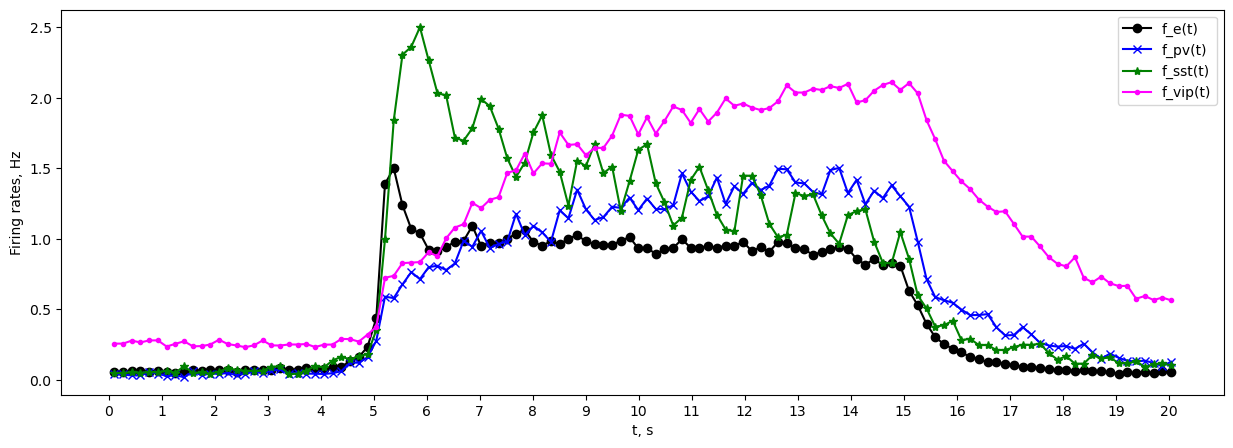

In [22]:
# Inicialization of new arrays to cut traces for suitable range

t_exp_1_new = []
pv_new = []
sst_new = []
vip_new = []
pc_all_new = []
pc_all_err_new = []
pv_err_new = []
sst_err_new = []
vip_err_new = []
pc_opto_pv_arch_new = []
pc_opto_pv_chr_new = []
pc_opto_sst_chr_new = []
pc_opto_sst_arch_new = []

# Cutting the traces
for ind, time in np.ndenumerate(t_exp_1):
    if (time >= 5) and (time <= 25):
        t_exp_1_new.append(time - 5)
        pv_new.append(pv[ind])
        sst_new.append(sst[ind])
        vip_new.append(vip[ind])
        pc_all_new.append(pc_all[ind])
        pv_err_new.append(pv_err[ind])
        sst_err_new.append(sst_err[ind])
        vip_err_new.append(vip_err[ind])
        pc_opto_pv_arch_new.append(pc_opto_pv_arch[ind])
        pc_opto_pv_chr_new.append(pc_opto_pv_chr[ind])
        pc_opto_sst_chr_new.append(pc_opto_sst_chr[ind])
        pc_opto_sst_arch_new.append(pc_opto_sst_arch[ind])
        pc_all_err_new.append(pc_all_err[ind])
        

# Adjusting for a missing initial point after deconvolution
pv_new.insert(0, pv_new[0])
sst_new.insert(0, sst_new[0])
vip_new.insert(0, vip_new[0])
pc_all_new.insert(0, pc_all_new[0])
pv_err_new.insert(0, pv_err_new[0])
sst_err_new.insert(0, sst_err_new[0])
vip_err_new.insert(0, vip_err_new[0])
pc_opto_pv_arch_new.insert(0, pc_opto_pv_arch_new[0])
pc_opto_pv_chr_new.insert(0, pc_opto_pv_chr_new[0])
pc_opto_sst_chr_new.insert(0, pc_opto_sst_chr_new[0])
pc_opto_sst_arch_new.insert(0, pc_opto_sst_arch_new[0])
pc_all_err_new.insert(0, pc_all_err_new[0])

t_exp_1_new.append(t_exp_1_new[-1] + dt)

# Plot traces
plt.figure(figsize=(15,5))
plt.plot(t_exp_1_new, pc_all_new, color='black', marker='o', label='f_e(t)')
plt.plot(t_exp_1_new, pv_new, color='blue', marker='x', label='f_pv(t)')
plt.plot(t_exp_1_new, sst_new, color='green', marker='*', label='f_sst(t)')
plt.plot(t_exp_1_new, vip_new, color='magenta', marker='.', label='f_vip(t)')

plt.legend(loc='best')
plt.ylabel(r'Firing rates, Hz')
plt.xlabel('t, s')
plt.xlim()
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

# Variables and constants

In [23]:
# This cell to set initial parameters and working parameters

t = np.float32(np.array(t_exp_1_new))
t_exp = t
threshold = np.float32(0) 

power = np.float32(2.0)
q = np.float32(1.0)

ampl_1 = 1.0

r_1 = np.float32(1.713939)
delay_1 = np.float32(0.1650418)
delay_2 = np.float32(1.73305)
delay_3 = np.float32(0.3695274)
decay = np.float32(3.324089)
decay_s = np.float32(0.2685497)
decay_f = np.float32(0.8342502)
decay_ff = np.float32(2.152722)
ampl = np.float32(1.0)
base = np.float32(1.0)
base_sigm = np.float32(0)
s_start = np.float32(0.1835884)
k = np.float32(0.03068755)

init = np.float32(np.array([0.055, 0.011, 0.017, 0.208, 0.055, 0.011, 0.017, 0.208]))
tau = np.float32(np.array([0.015, 0.0075, 0.019, 0.019]))
i = np.float32(np.array([0.26580502, 0.01447602, 0.11203215, 0.51341198]))
w = np.float32(np.array([
              0.08281103, # w_0  PC  -> PC        
              1.51969985, # w_1  FF  -> PC
              1.06618999, # w_2  SM   -> PC
              1.95560664, # w_3  PV -> PC
              0.63190096, # w_4  SST  -> PC
              0.20723919, # w_5  PC   -> PV
              0.92636845, # w_6  FF  -> PV
              2.11169434, # w_7  SM -> PV
              1.51029559, # w_8  PV   -> PV
              0.25013329, # w_9  SST  -> PV
              0.78370724, # w_10 PC -> SST
              0.59415933, # w_11 FB  -> SST
              0.14997032, # w_12 VIP  -> SST
              0.32398988, # w_13 PC  -> VIP
              0.19112577, # w_14 SST  -> VIP
              0.73762300, # w_15 SM  -> VIP
              1.14600083, # w_16 FB  -> PC
              0.17580747, # w_17 FB  -> PV
              0.15806817]))# w_18 FB -> VIP



data_pv = np.float32(np.array(pv_new)) 
data_sst = np.float32(np.array(sst_new)) 
data_vip = np.float32(np.array(vip_new)) 
data_pc_all = np.float32(np.array(pc_all_new))

data_pc_opto_pv_arch = np.float32(np.array(pc_opto_pv_arch_new))
data_pc_opto_pv_chr = np.float32(np.array(pc_opto_pv_chr_new))
data_pc_opto_sst_chr = np.float32(np.array(pc_opto_sst_chr_new))
data_pc_opto_sst_arch = np.float32(np.array(pc_opto_sst_arch_new))

pc_all_err_new = np.array(pc_all_err_new)
pv_err_new = np.array(pv_err_new)
sst_err_new = np.array(sst_err_new)
vip_err_new = np.array(vip_err_new)


count = 0
max_nfev = 2000

## Parameters

In [24]:
"""
Setting lmfit.Parameters() object with all parameters for the model,
their initial values, ranges and boolean varaible wether to vary them or not during fitting
"""

params = Parameters()
params.add('w_0', value = w[0] , vary = True, min = 0.05, max = 6)
params.add('w_1', value = w[1] , vary = True, min = 0.0, max = 6)
params.add('w_2', value = w[2] , vary = True, min = 0.0, max = 6)
params.add('w_3', value = w[3] , vary = True, min = 0.0, max = 6)
params.add('w_4', value = w[4] , vary = True, min = 0.0, max = 6)
params.add('w_5', value = w[5] , vary = True, min = 0.0, max = 6)
params.add('w_6', value = w[6] , vary = True, min = 0.0, max = 6)
params.add('w_7', value = w[7] , vary = True, min = 0.0, max = 6)
params.add('w_8', value = w[8] , vary = True, min = 0.0, max = 6)
params.add('w_9', value = w[9] , vary = True, min = 0.0, max = 6)
params.add('w_10', value = w[10] , vary = True, min = 0.0, max = 6)
params.add('w_11', value = w[11] , vary = True, min = 0.0, max = 6)
params.add('w_12', value = w[12] , vary = True, min = 0.0, max = 6)
params.add('w_13', value = w[13] , vary = True, min = 0.3, max = 6)
params.add('w_14', value = w[14] , vary = True, min = 0.0, max = 6)
params.add('w_15', value = w[15] , vary = True, min = 0.0, max = 6)
params.add('w_16', value = w[16] , vary = True, min = 0.0, max = 6)
params.add('w_17', value = w[17] , vary = True, min = 0.0, max = 6)
params.add('w_18', value = w[18] , vary = True, min = 0.0, max = 6)

params.add('tau_0', value = tau[0] , vary = False, min = 0.001, max = 0.03)
params.add('tau_1', value = tau[1] , vary = False, min = 0.001, max = 0.03)
params.add('tau_2', value = tau[2] , vary = False, min = 0.001, max = 0.03)
params.add('tau_3', value = tau[3] , vary = False, min = 0.001, max = 0.03)
params.add('threshold', value = threshold , vary = False, min = -np.inf, max = np.inf)
params.add('power', value = power , vary = False, min = 0.5, max = 2.5)
params.add('q', value = q, vary = False, min = 0.001, max = 2.5 )
params.add('i_0', value = i[0] , vary = True, min = 0.0, max = 0.7)
params.add('i_1', value = i[1] , vary = True, min = 0.0, max = 0.7)
params.add('i_2', value = i[2] , vary = True, min = 0.0, max = 0.7)
params.add('i_3', value = i[3] , vary = True, min = 0.0, max = 0.7)

params.add('ampl_1', value = ampl_1 , vary = False, min = 0.8, max = 1.5)
params.add('r_1', value = r_1, vary = True, min = 0, max = 5)
params.add('delay_1', value = delay_1, vary = True, min = 0, max = 1.5)
params.add('delay_2', value = delay_2, vary = True, min = 0, max = 25)
params.add('delay_3', value = delay_3, vary = True, min = 0, max = 3)
params.add('decay', value = decay, vary = True, min = 0, max = 10)
params.add('decay_s', value = decay_s, vary = True, min = 0, max = 10)
params.add('decay_f', value = decay_f, vary = True, min = 0, max = 10)
params.add('decay_ff', value = decay_ff, vary = True, min = 0, max = 10)
params.add('ampl', value = ampl, vary = True, min = 0, max = 5)
params.add('base', value = base, vary = False, min = 0, max = 5)
params.add('base_sigm', value = base_sigm, vary = False, min = 0, max = 2)
params.add('s_start', value = s_start, vary = True, min = 0, max = 4)
params.add('k', value = k, vary = True, min = 0.03, max = 2)
params

name,value,initial value,min,max,vary
w_0,0.08281103,0.08281102776527405,0.05000000,6.00000000,True
w_1,1.51969981,1.5196998119354248,0.00000000,6.00000000,True
w_2,1.06619000,1.0661900043487549,0.00000000,6.00000000,True
w_3,1.95560670,1.9556066989898682,0.00000000,6.00000000,True
w_4,0.63190097,0.63190096616745,0.00000000,6.00000000,True
w_5,0.20723920,0.20723919570446014,0.00000000,6.00000000,True
w_6,0.92636847,0.9263684749603271,0.00000000,6.00000000,True
w_7,2.11169434,2.1116943359375,0.00000000,6.00000000,True
w_8,1.51029563,1.5102956295013428,0.00000000,6.00000000,True
w_9,0.25013328,0.2501332759857178,0.00000000,6.00000000,True


In [25]:
# Slider feature. Could be ommited if slider wont be used.

w_0 = params['w_0'].value
w_1 = params['w_1'].value
w_2 = params['w_2'].value
w_3 = params['w_3'].value
w_4 = params['w_4'].value
w_5 = params['w_5'].value
w_6 = params['w_6'].value
w_7 = params['w_7'].value
w_8 = params['w_8'].value
w_9 = params['w_9'].value
w_10 = params['w_10'].value
w_11 = params['w_11'].value
w_12 = params['w_12'].value
w_13 = params['w_13'].value
w_14 = params['w_14'].value
w_15 = params['w_15'].value
w_16 = params['w_16'].value
w_17 = params['w_17'].value
w_18 = params['w_18'].value
    
tau_0 = params['tau_0'].value
tau_1 = params['tau_1'].value
tau_2 = params['tau_2'].value
tau_3 = params['tau_3'].value
threshold = params['threshold'].value
power = params['power'].value
q = params['q'].value
i_0 = params['i_0'].value
i_1 = params['i_1'].value
i_2 = params['i_2'].value
i_3 = params['i_3'].value
ampl_1 = params['ampl_1'].value
r_1 = params['r_1'].value
delay_1 = params['delay_1'].value
delay_2 = params['delay_2'].value
delay_3 = params['delay_3'].value
decay = params['decay'].value
decay_s = params['decay_s'].value
decay_f = params['decay_f'].value
decay_ff = params['decay_ff'].value
ampl = params['ampl'].value
base = params['base'].value
base_sigm = params['base_sigm'].value
s_start = params['s_start'].value
k = params['k'].value

In [26]:
# Slider feature. Could be ommited if slider wont be used. Set widget.FloatSlider() insted fixed() to add parameter to slider.

%matplotlib inline
from ipywidgets import interactive, fixed
import ipywidgets as widgets
interactive(slider, 
            w_0 = fixed(w_0), # widgets.IntSlider(min=0, max=2, step=0.1, value=w_0)
            w_1=fixed(w_1), w_2=fixed(w_2), w_3=widgets.FloatSlider(min=0, max=5, step=0.1, value=w_3), w_4=widgets.FloatSlider(min=0, max=7, step=0.1, value=w_4), w_5=fixed(w_5), 
            w_6=fixed(w_6), w_7=widgets.FloatSlider(min=0, max=3, step=0.1, value=w_7), w_8=fixed(w_8), w_9=fixed(w_9), w_10=fixed(w_10), 
            w_11=fixed(w_11), w_12=fixed(w_12), w_13=fixed(w_13), w_14=fixed(w_14), w_15=fixed(w_15), 
            w_16=fixed(w_16), w_17=fixed(w_17), w_18=fixed(w_18), 
            tau_0=fixed(tau_0), tau_1=fixed(tau_1), tau_2=fixed(tau_2), tau_3=fixed(tau_3),
            threshold=fixed(threshold), power=fixed(power), q=fixed(q),
            i_0=fixed(i_0), i_1=fixed(i_1), i_2=fixed(i_2), i_3=fixed(i_3),
            r_1=fixed(r_1), decay=fixed(decay), delay_1=fixed(delay_1), delay_2=fixed(delay_2), delay_3=fixed(delay_3), ampl=fixed(ampl),
            base=fixed(base), decay_s=fixed(decay_s), ampl_1=fixed(ampl_1), base_sigm=fixed(base_sigm), decay_f=fixed(decay_f), decay_ff=fixed(decay_ff), s_start=fixed(s_start), k=fixed(k))

interactive(children=(FloatSlider(value=1.9556066989898682, description='w_3', max=5.0), FloatSlider(value=0.6…

In [27]:
# Simulate a model with parameters defimed in params

model = simulate_step(t_exp, init, params)

In [28]:
# Write csv file with output
# model[['t', 'f_e_o']].to_csv('out_sst_chr_2024-11-06.csv', index=False)

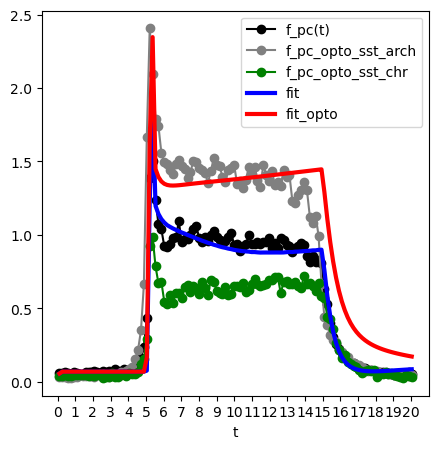

In [29]:
# Plot model against PC_average data and model with optogenetic against opto data. Non required opto are commented out.
# In a current version optogenetic predictions realised through the simulation from initial parameters.
# This means that after fitting one needs to update initial parameters with fitted and check opto predictions.
# Opto manipulation is in the function, where system of equations is described.

plt.figure(figsize=(5,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')

#plt.plot(t_exp, data_pc_opto_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_opto_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
plt.plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
plt.plot(t_exp, data_pc_opto_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')

plt.plot(t_exp, model['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_e_o'].values, color='red', label='fit_opto', linewidth=3)

plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [30]:
a = RMSE(params, init, data_pc_opto_pv_arch, "f_e_o")
print(a)

0.11050454980119635


In [31]:
a_tot = RMSE_full(params, init, data_pc_all, data_pv, data_sst, data_vip)
print(a_tot)

0.11410533931115799


In [32]:
a_tot_1 = RMSE_full_1(params, init, data_pc_all, data_pv, data_sst, data_vip)
print(a_tot_1)

0.09315313214718823


In [33]:
#model[['t', 'f_e_o']].to_csv('trace_s1_hab_Loco_PVArch_30_05_2025.csv', index=False)

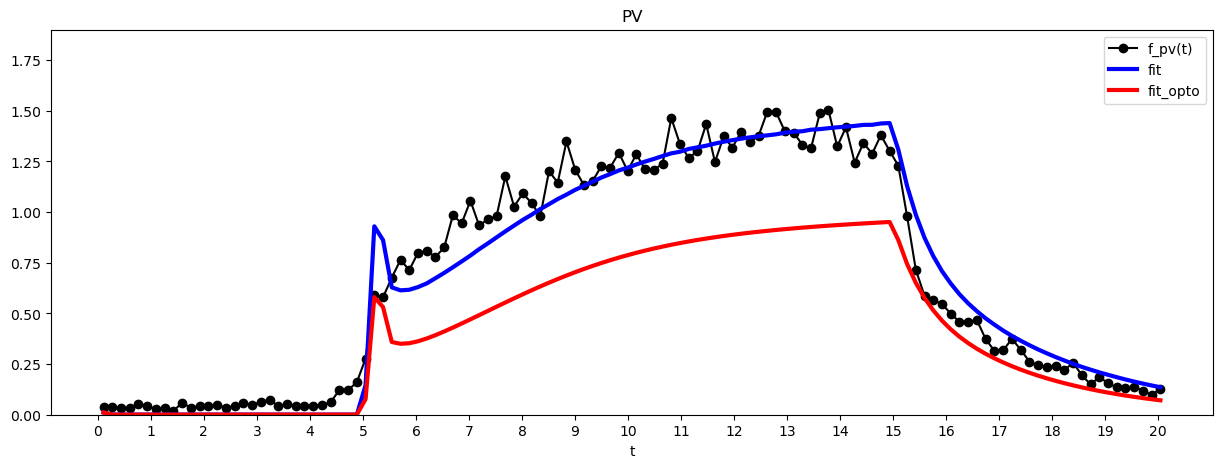

In [34]:
# PV data, model and opto effect

plt.figure(figsize=(15,5))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')

plt.plot(t_exp, model['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)


plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 1.9)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [35]:
"""
Opto effect calculation on PV
"""

#print(model['f_pv'].values)
#print(model['f_pv_o'].values)
#print(model['f_pv'].values/model['f_pv_o'].values)
#print((model['f_pv'].values/model['f_pv_o'].values).mean())
#print((model['f_pv_o'].values/model['f_pv'].values).mean())
print(model['f_pv'].values.mean()/model['f_pv_o'].values.mean())
print(model['f_pv_o'].values.mean()/model['f_pv'].values.mean())

1.5669425179914134
0.6381855036276959


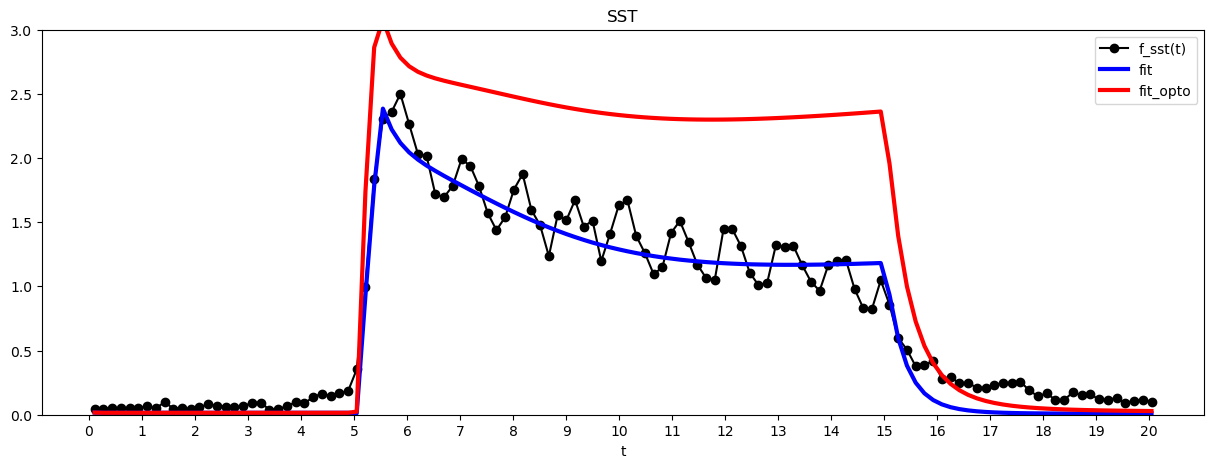

In [36]:
# SST data, model and opto effect

plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, model['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylim(0, 3.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

In [37]:
"""
Opto effect calculation on SST
"""

# print(model['f_sst'].values)
# print(model['f_sst_o'].values)
# print(model['f_sst'].values/model['f_sst_o'].values)
# print((model['f_sst'].values/model['f_sst_o'].values).mean())
# print((model['f_sst_o'].values/model['f_sst'].values).mean())
print(model['f_sst'].values.mean()/model['f_sst_o'].values.mean())
print(model['f_sst_o'].values.mean()/model['f_sst'].values.mean())

0.5775490409299355
1.7314546975783367


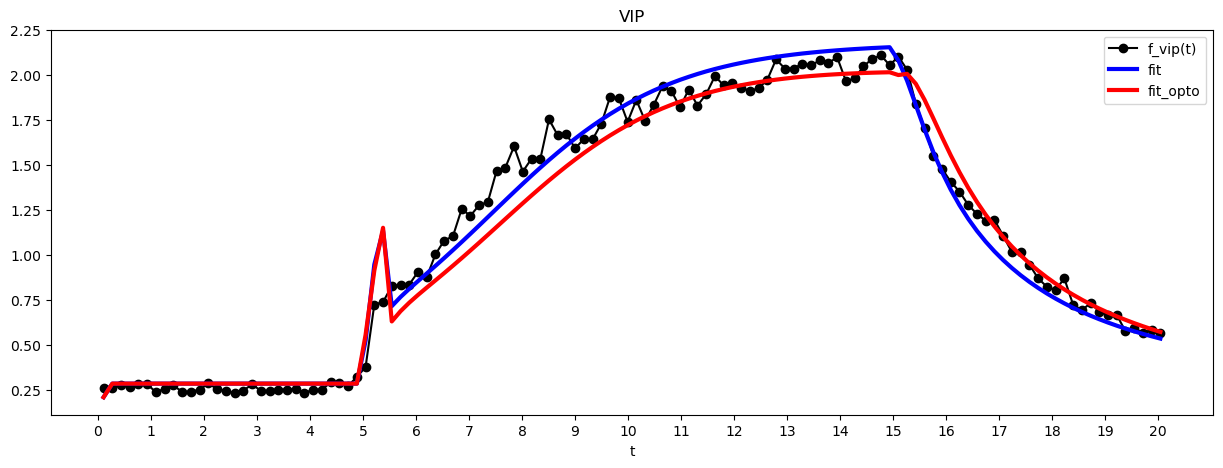

In [38]:
# VIP data, model and opto effect

plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')

plt.plot(t_exp, model['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

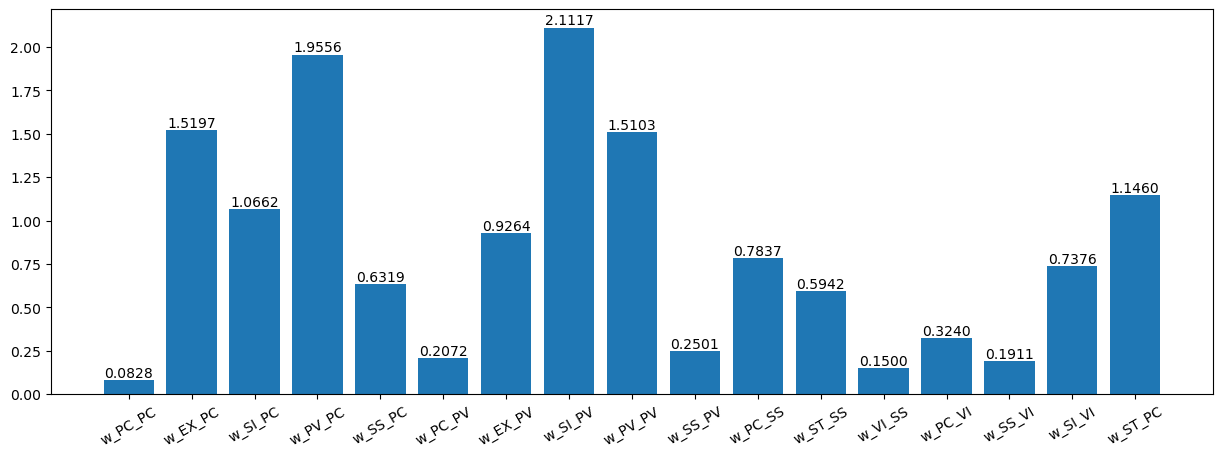

In [39]:
vals = []
for _, param in params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

# Fitting model to a data with different algorithms

## leastsq (Levenberg-Marquardt)

In [40]:
count = 0

In [41]:
"""
Next cell is a fiting process itself.
For more details on the minimize() function please refer to LMFIT documentation.
max_nfev parameter states maximum evaluation functions that will be run during fitting in attempt to minimize residual function and meet set accuracy.
In some cases max-nfev was set to low values to run only nelder algorythm wich one as we found was performing better for initial conditions set as 0.5 before fine tuning
"""
print()

'\nNext cell is a fiting process itself.\nFor more details on the minimize() function please refer to LMFIT documentation.\nmax_nfev parameter states maximum evaluation functions that will be run during fitting in attempt to minimize residual function and meet set accuracy.\nIn some cases max-nfev was set to low values to run only nelder algorythm wich one as we found was performing better for initial conditions set as 0.5 before fine tuning\n'

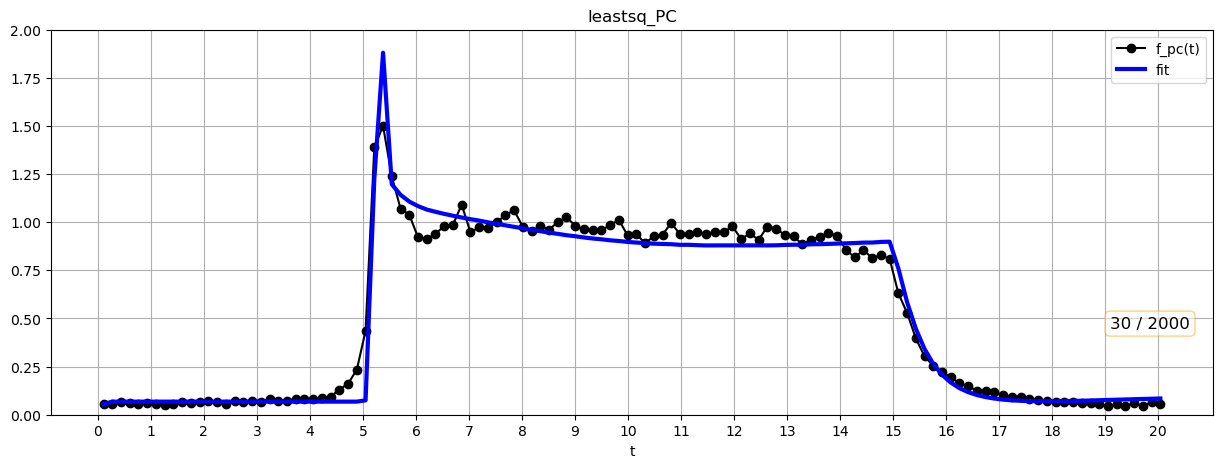


CPU times: total: 20.9 s
Wall time: 21 s


In [42]:
%%time
%matplotlib inline

result_leastsq = minimize(residual_step, params, method='least_squares', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=30, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [43]:
# Fitting results

report_fit(result_leastsq)

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 30
    # data points      = 488
    # variables        = 34
    chi-square         = 4523.68628
    reduced chi-square = 9.96406670
    Akaike info crit   = 1154.66234
    Bayesian info crit = 1297.13306
##  Warning: uncertainties could not be estimated:
    w_0:        at initial value
    w_1:        at initial value
    w_2:        at initial value
    w_3:        at initial value
    w_4:        at initial value
    w_5:        at initial value
    w_6:        at initial value
    w_7:        at initial value
    w_8:        at initial value
    w_9:        at initial value
    w_10:       at initial value
    w_11:       at initial value
    w_12:       at initial value
    w_13:       at initial value
    w_14:       at initial value
    w_15:       at initial value
    w_16:       at initial value
    w_17:       at initial value
    w_18:       at initial value
    i_0:        at initial value
  

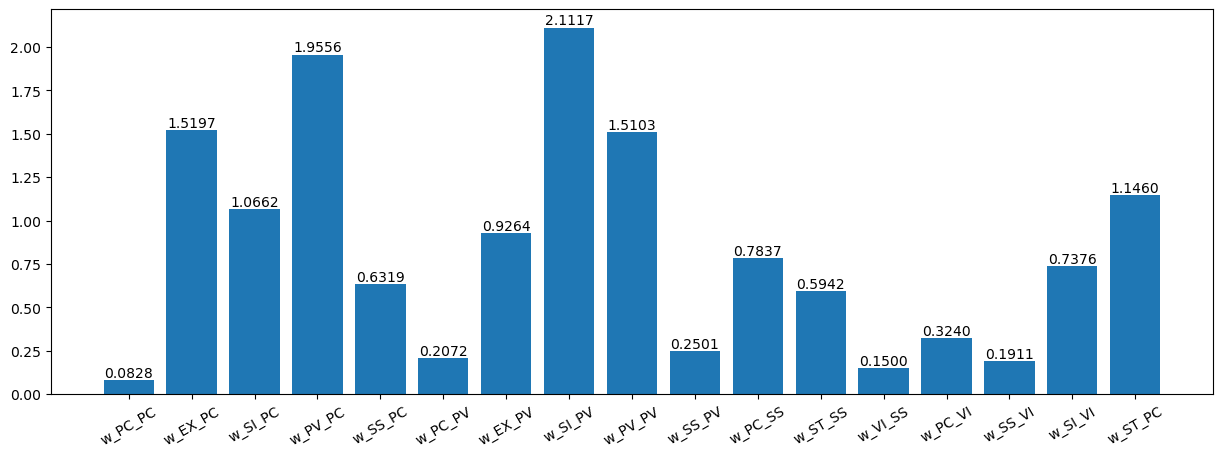

In [44]:
vals = []
for _, param in result_leastsq.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

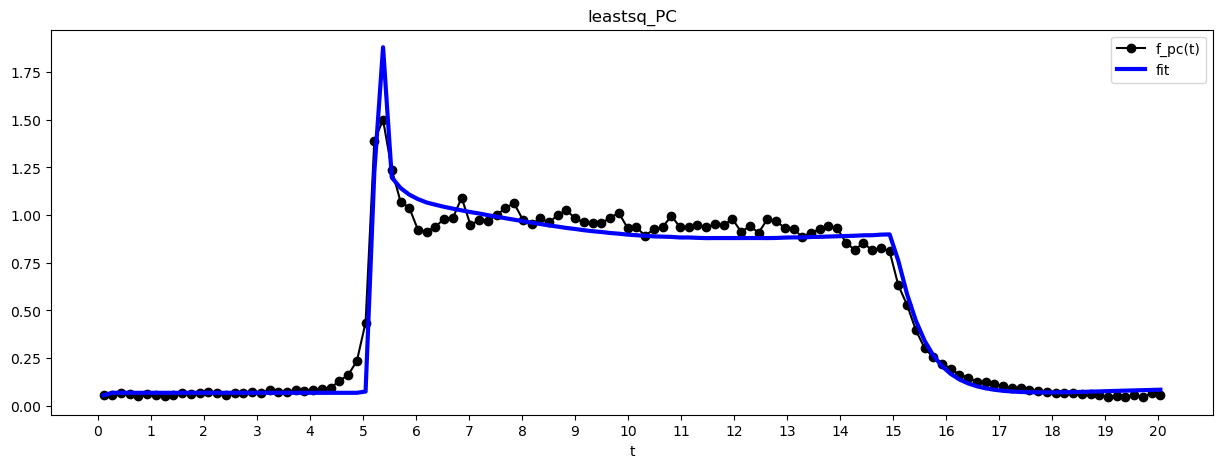

In [45]:
# Simulation of fitted data and comparisson to PC

sim_leastsq = simulate_step(t_exp, init, params)
fit_leastsq = simulate_step(t_exp, init, result_leastsq.params)
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsq['f_e'].values, color='blue', label='fit', linewidth=3)

plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

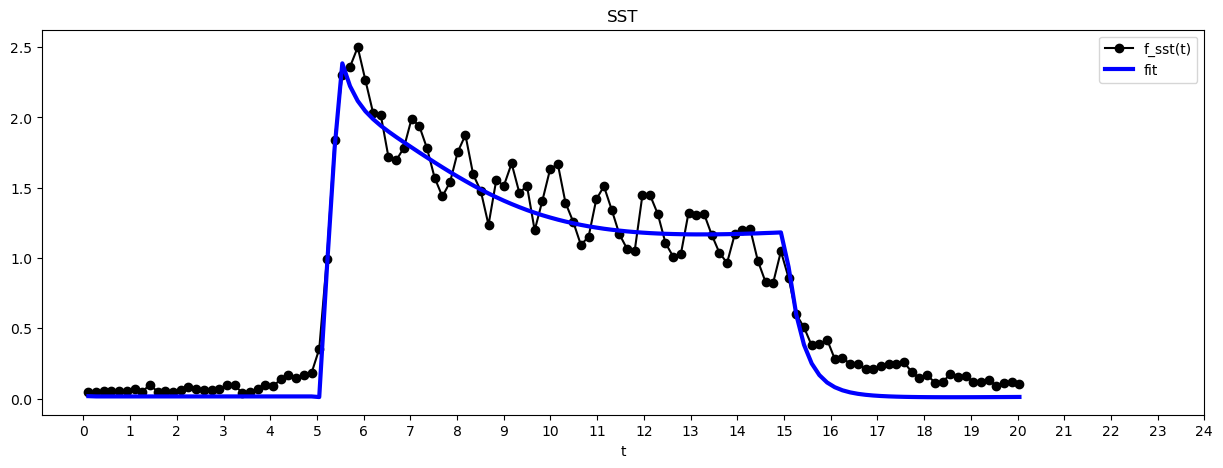

In [46]:
# comparisson to SST

plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsq['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

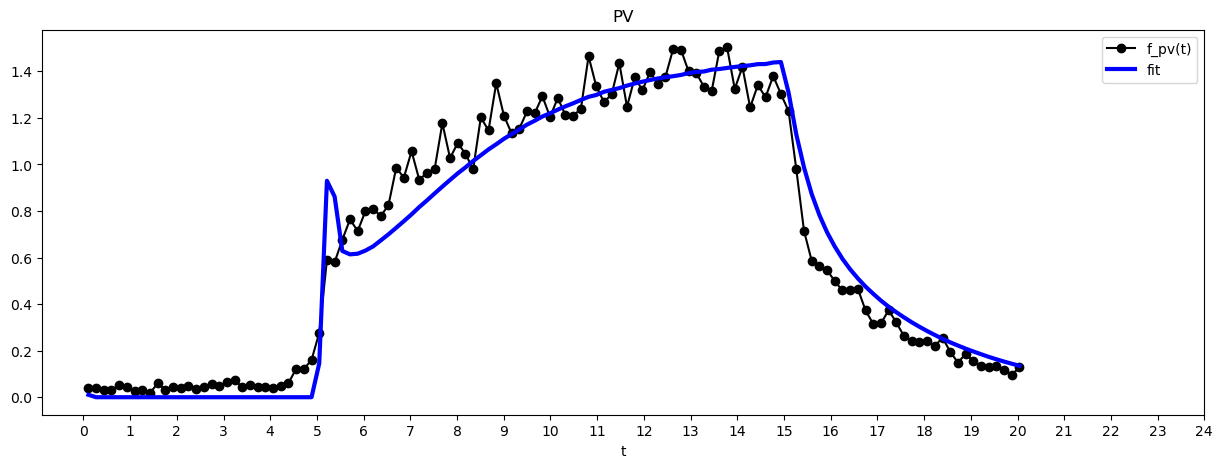

In [47]:
# comparisson to PV

plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsq['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

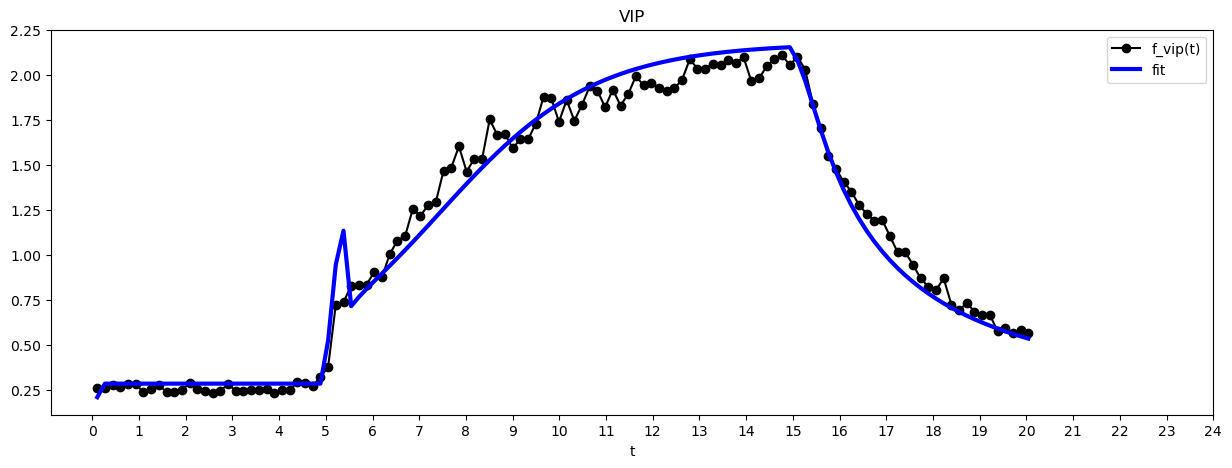

In [48]:
# comparisson to VIP

plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsq['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

## least_squares

In [49]:
count = 0

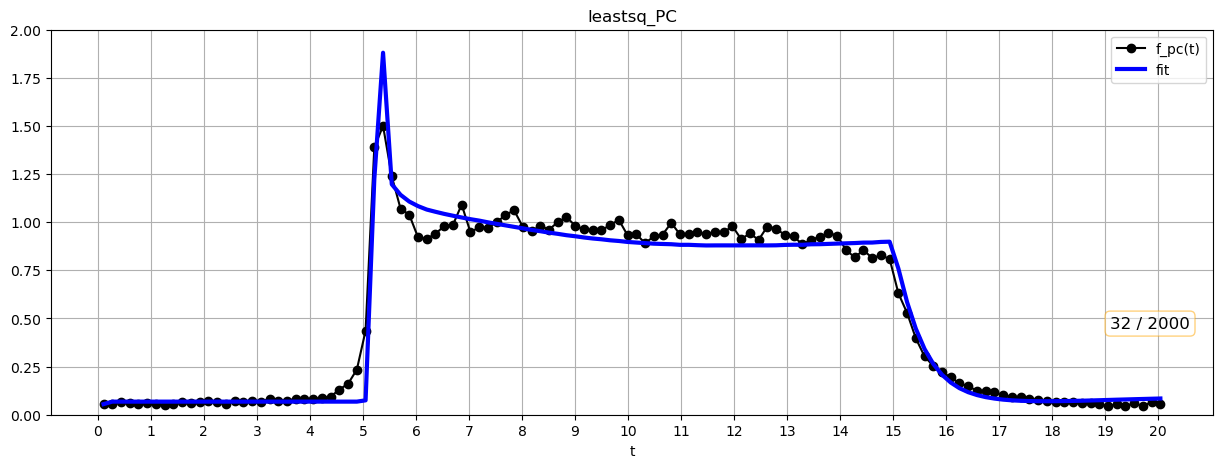


CPU times: total: 22.8 s
Wall time: 22.8 s


In [50]:
%%time
%matplotlib inline

result_leastsqs = minimize(residual_step, params, method='leastsq', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=30, ftol=1e-15, gtol=1e-15, xtol=1e-15)
print()


In [51]:
report_fit(result_leastsqs)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 488
    # variables        = 34
    chi-square         = 4523.70476
    reduced chi-square = 9.96410741
    Akaike info crit   = 1154.66433
    Bayesian info crit = 1297.13505
##  Warning: uncertainties could not be estimated:
    w_0:        at initial value
    w_1:        at initial value
    w_2:        at initial value
    w_3:        at initial value
    w_4:        at initial value
    w_5:        at initial value
    w_6:        at initial value
    w_7:        at initial value
    w_8:        at initial value
    w_9:        at initial value
    w_10:       at initial value
    w_11:       at initial value
    w_12:       at initial value
    w_13:       at initial value
    w_14:       at initial value
    w_15:       at initial value
    w_16:       at initial value
    w_17:       at initial value
    w_18:       at initial value
    i_0:        at initial value
    i_1:

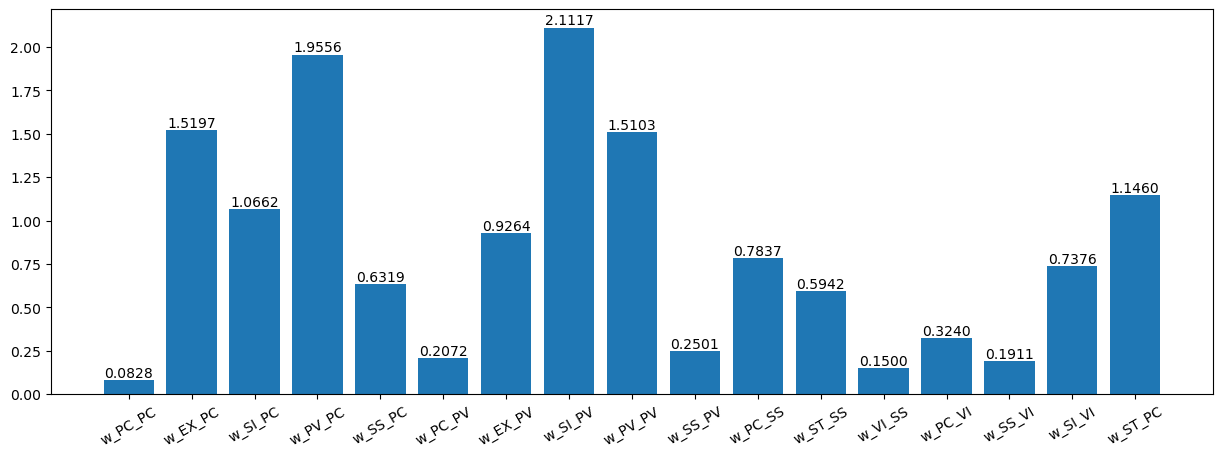

In [52]:
vals = []
for _, param in result_leastsqs.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

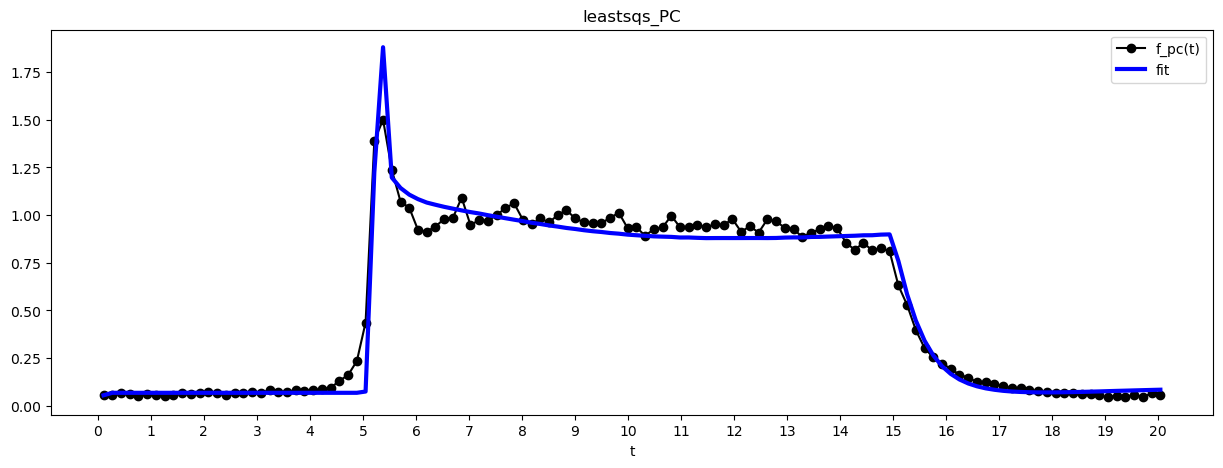

In [53]:
sim_leastsqs = simulate_step(t_exp, init, params)
fit_leastsqs = simulate_step(t_exp, init, result_leastsqs.params)
    
plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_leastsqs['f_e'].values, color='blue', label='fit', linewidth=3)

plt.title('leastsqs_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

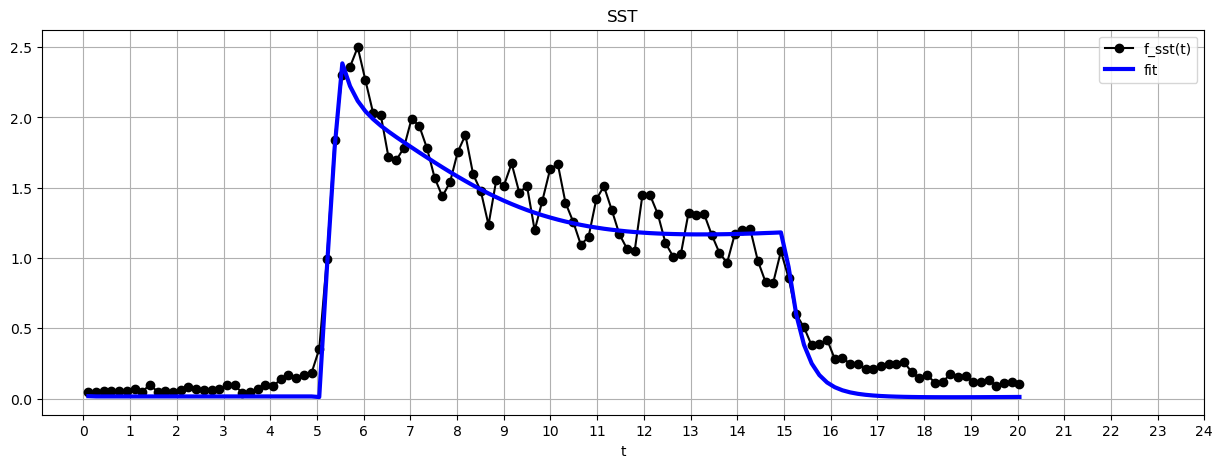

In [54]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_leastsqs['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

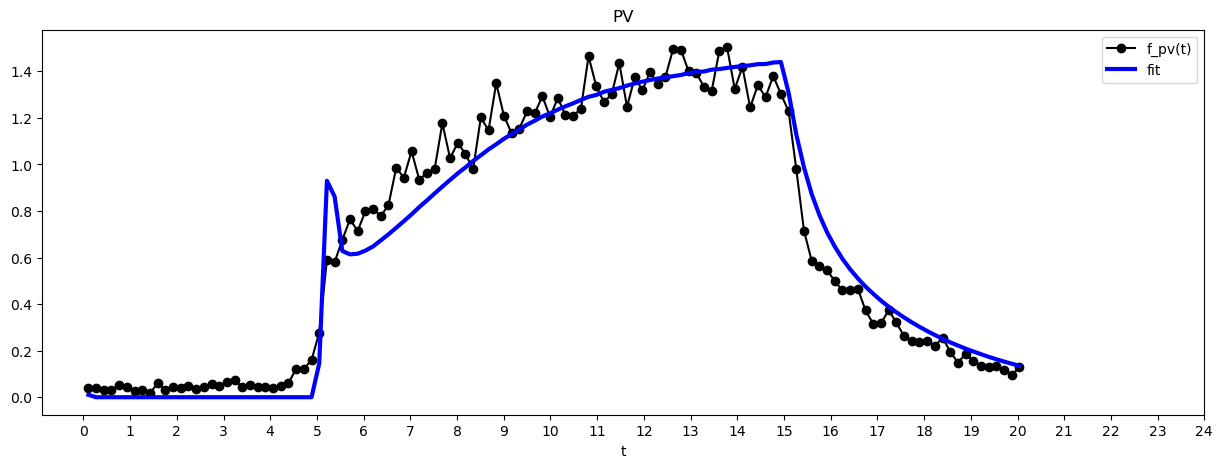

In [55]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_leastsqs['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

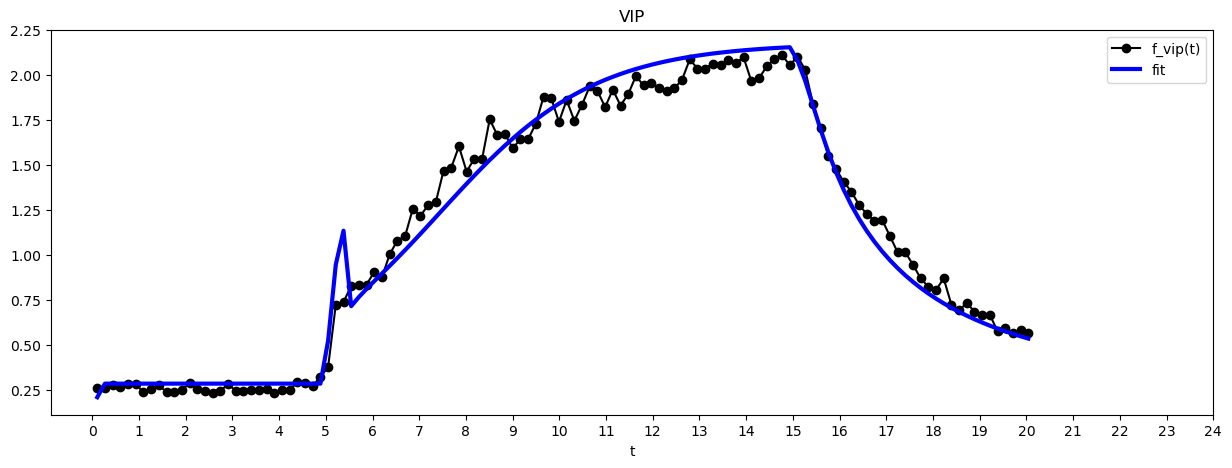

In [56]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_leastsqs['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_leastsq['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

## nelder

In [57]:
count = 0

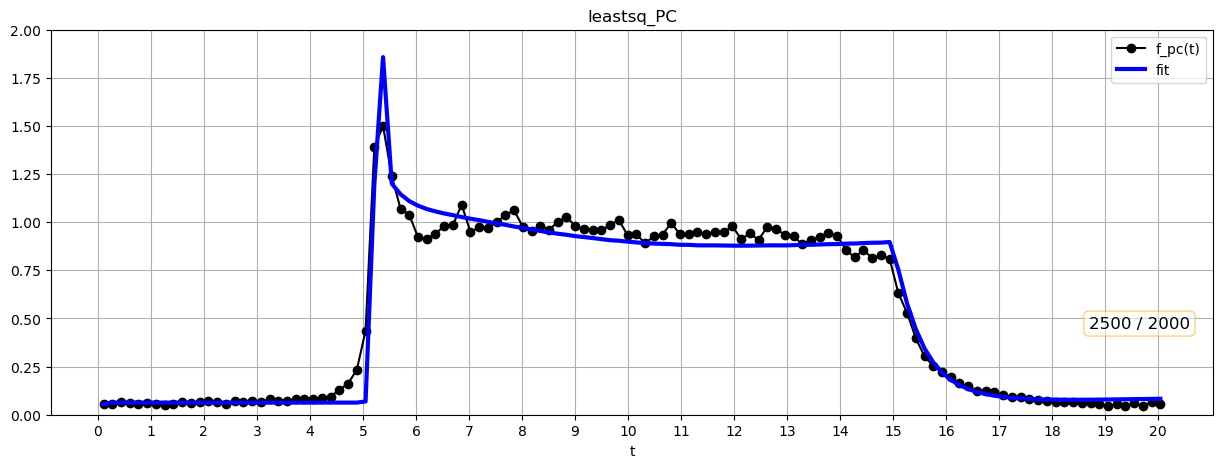


CPU times: total: 28min 42s
Wall time: 28min 54s


In [58]:
%%time

%matplotlib inline

result_nelder = minimize(residual_step, params, method='nelder', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), nan_policy='propagate', options = {'adaptive' : True}, max_nfev = 2500)
print()


In [59]:
report_fit(result_nelder)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2501
    # data points      = 488
    # variables        = 34
    chi-square         = 4251.40146
    reduced chi-square = 9.36432040
    Akaike info crit   = 1124.36802
    Bayesian info crit = 1266.83874
##  Warning: uncertainties could not be estimated:
[[Variables]]
    w_0:        0.07891690 (init = 0.08281103)
    w_1:        1.53043917 (init = 1.5197)
    w_2:        1.04803381 (init = 1.06619)
    w_3:        1.96335548 (init = 1.955607)
    w_4:        0.62369759 (init = 0.631901)
    w_5:        0.21962470 (init = 0.2072392)
    w_6:        0.93110816 (init = 0.9263685)
    w_7:        2.09942802 (init = 2.111694)
    w_8:        1.51868943 (init = 1.510296)
    w_9:        0.24532642 (init = 0.2501333)
    w_10:       0.79175017 (init = 0.7837073)
    w_11:       0.56290698 (init = 0.5941593)
    w_12:       0.15238532 (init = 0.1499703)
    w_13:       0.30285707 (init = 0.3239899)
    w_14:   

In [60]:
# RMSE calculation

a_nelder = RMSE_full(result_nelder.params, init, data_pc_all, data_pv, data_sst, data_vip)
print(a_nelder)

0.11034065565197593


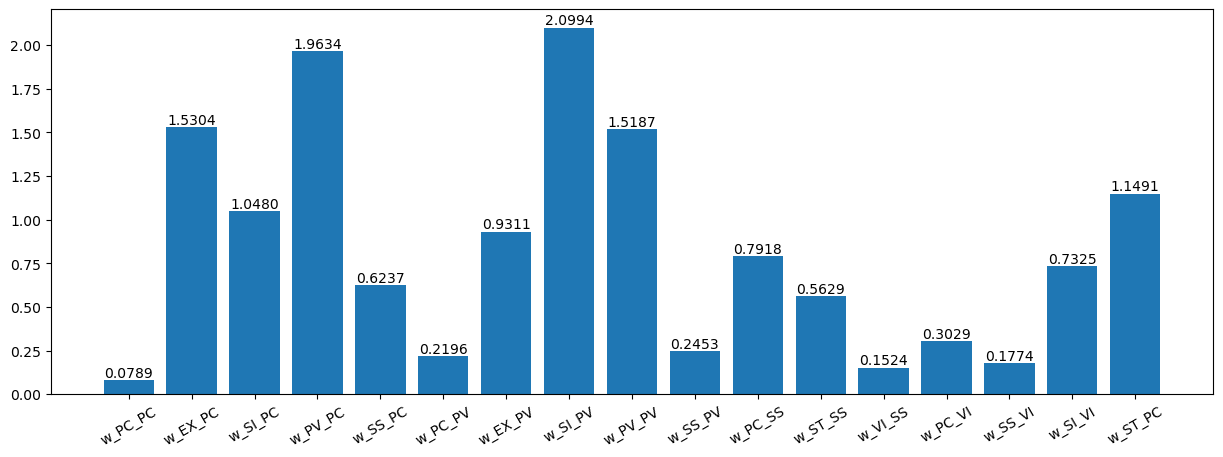

In [61]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

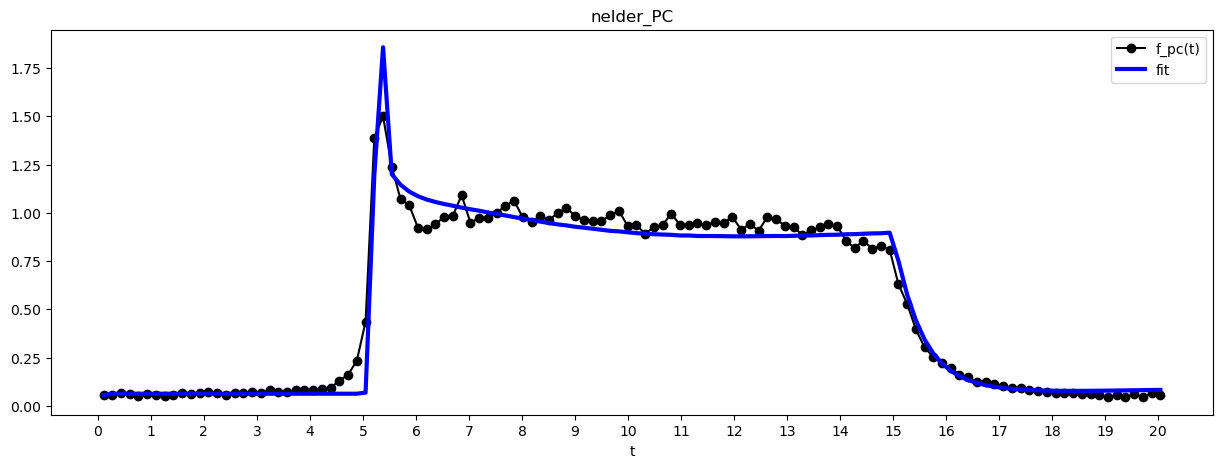

In [62]:
sim_nelder = simulate_step(t_exp, init, params)
fit_nelder = simulate_step(t_exp, init, result_nelder.params)

plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_nelder['f_e'].values, color='blue', label='fit', linewidth=3)

plt.title('nelder_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 5)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

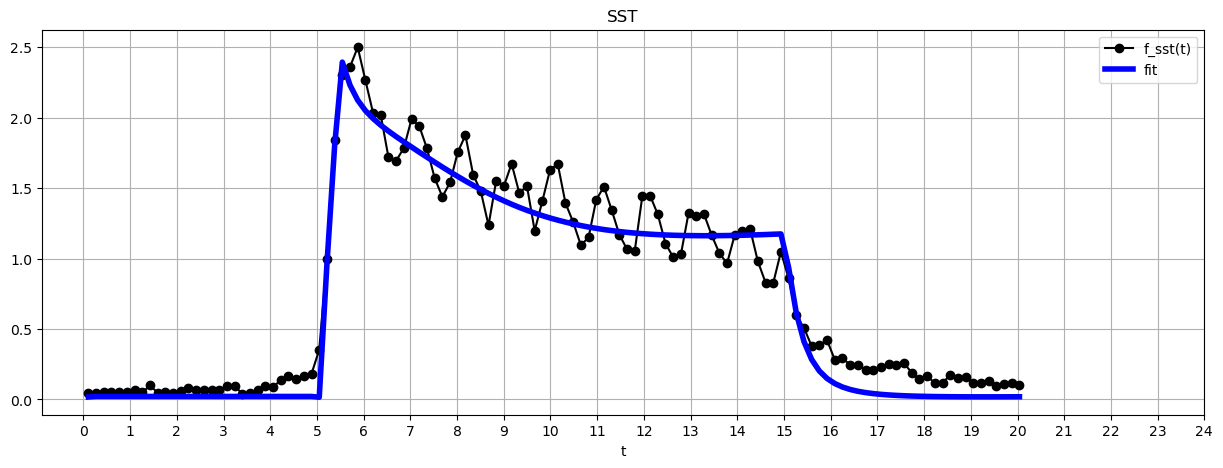

In [63]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_nelder['f_sst'].values, color='blue', label='fit', linewidth=4)

plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.ylim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

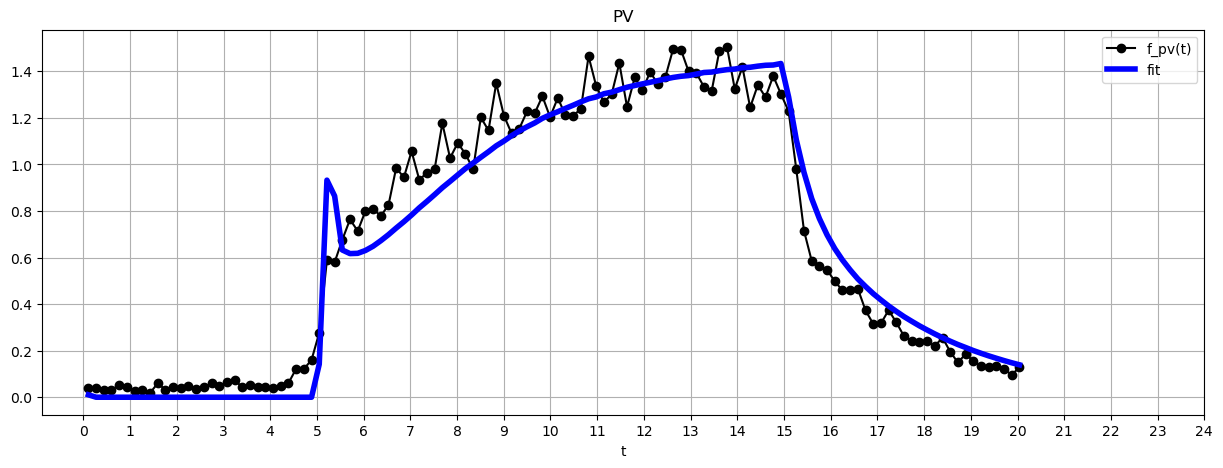

In [64]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_nelder['f_pv'].values, color='blue', label='fit', linewidth=4)

plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

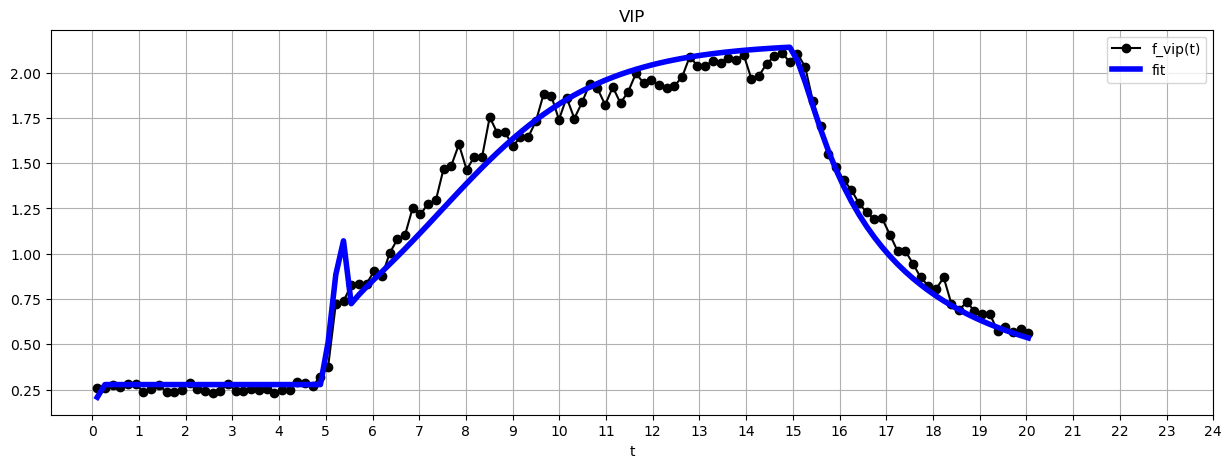

In [65]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_nelder['f_vip'].values, color='blue', label='fit', linewidth=4)

plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
#plt.grid()
plt.show()

In [66]:
model_opto = simulate_step(t_exp, init, result_nelder.params)

In [67]:
# Saving results as .csv

# model_opto[['t', 'f_e', 'f_pv', 'f_sst', 'f_vip']].to_csv('traces_s1_hab_Loco_27_03_2025.csv', index=False)

In [68]:
# Saving results as .csv

# model_opto[['t', 'f_e_o']].to_csv('trace_s1_hab_Loco_PVChr_27_03_2025.csv', index=False)

In [69]:
# Opto RMSE (change data for different opto cases). Dont forget also update opto scenario in model_step() function

a = RMSE(result_nelder.params, init, data_pc_opto_sst_chr, "f_e_o")
print(a)

0.527882259650129


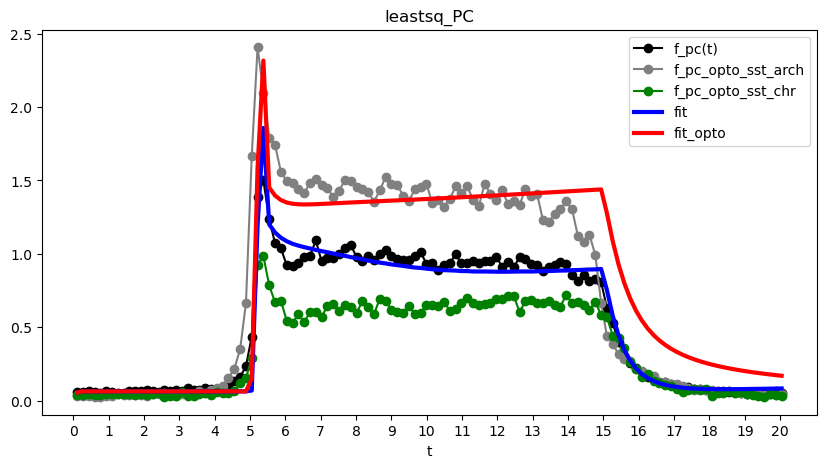

In [70]:
plt.figure(figsize=(10,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')

#different opto scenarios. Only two presented not to owerwhelm the figure
#plt.plot(t_exp, data_pc_opto_pv_arch, color='gray', marker='o', label='f_pc_opto_pv_arch')
#plt.plot(t_exp, data_pc_opto_pv_chr, color='green', marker='o', label='f_pc_opto_pv_chr')
plt.plot(t_exp, data_pc_opto_sst_arch, color='gray', marker='o', label='f_pc_opto_sst_arch')
plt.plot(t_exp, data_pc_opto_sst_chr, color='green', marker='o', label='f_pc_opto_sst_chr')


plt.plot(t_exp, model_opto['f_e'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_e_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('leastsq_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.xlim(3,7)
#plt.grid()
plt.show()

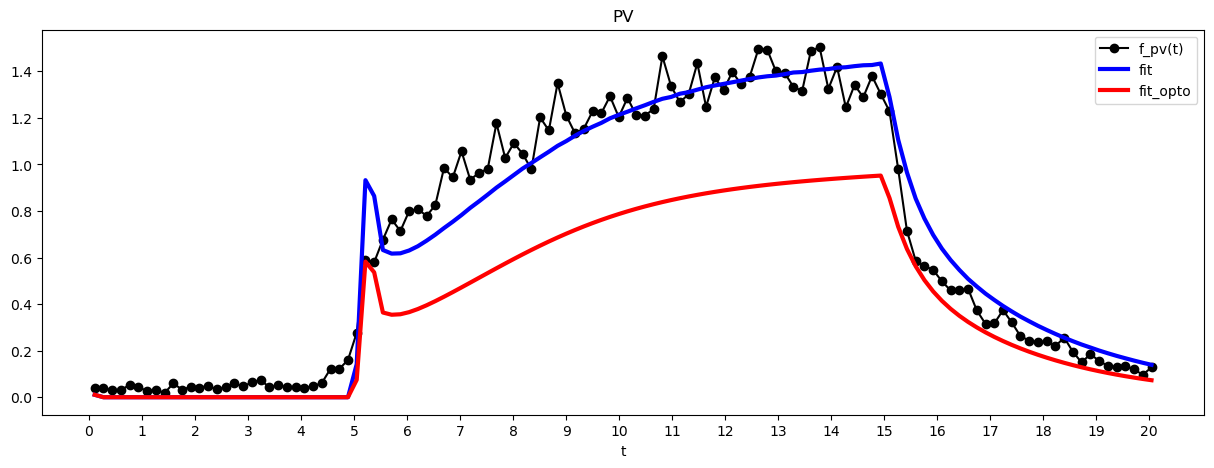

In [71]:
plt.figure(figsize=(15,5))

plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')

plt.plot(t_exp, model_opto['f_pv'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_pv_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

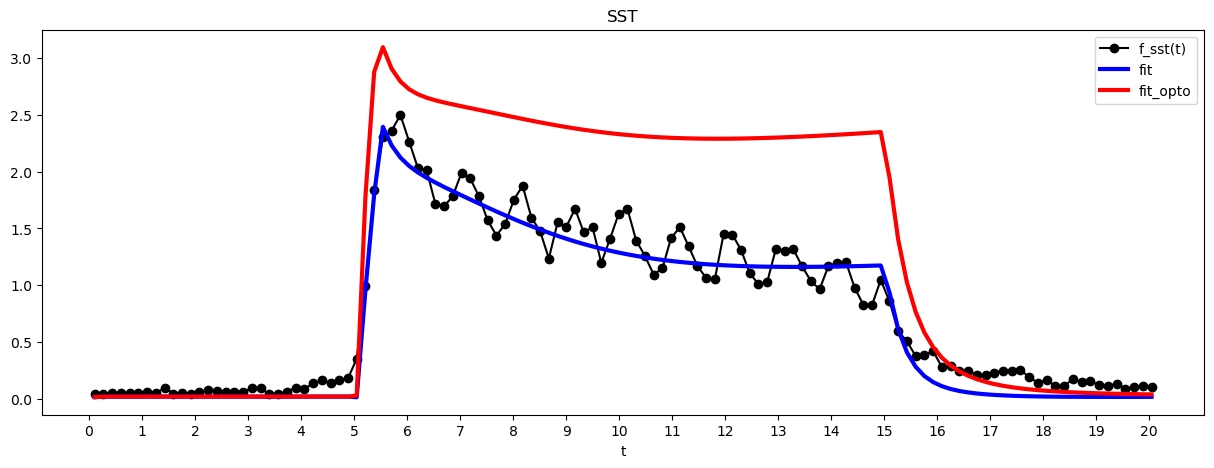

In [72]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')

plt.plot(t_exp, model_opto['f_sst'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_sst_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 1.0)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

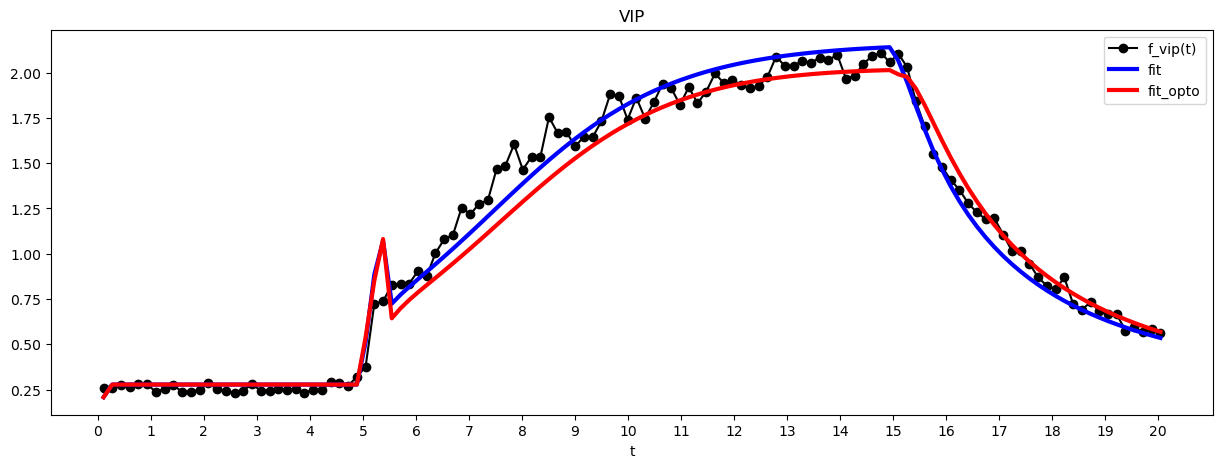

In [73]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')

plt.plot(t_exp, model_opto['f_vip'].values, color='blue', label='fit', linewidth=3)
plt.plot(t_exp, model_opto['f_vip_o'].values, color='red', label='fit_opto', linewidth=3)

plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(0, 2.2)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

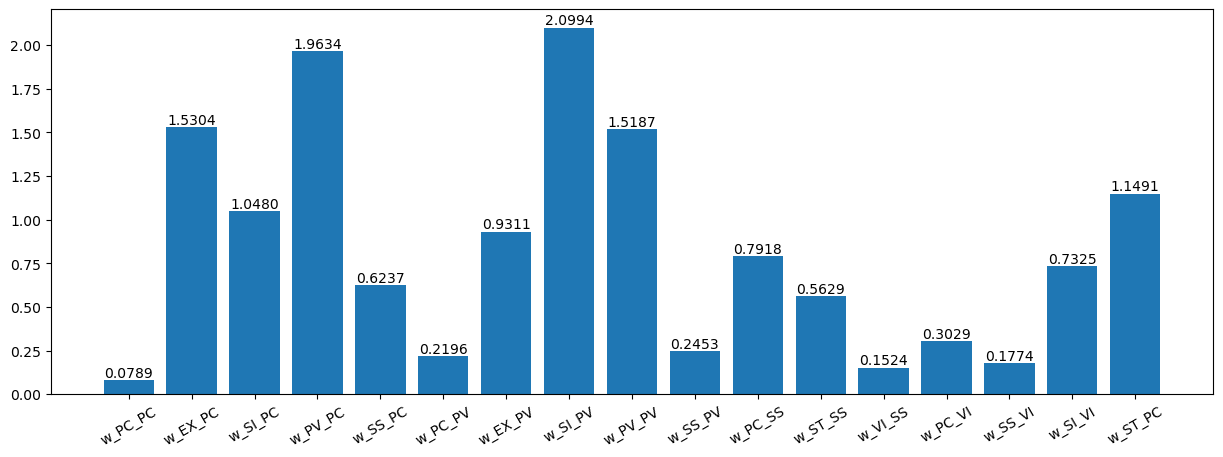

In [74]:
vals = []
for _, param in result_nelder.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

In [75]:
# Was introduced as temporary solution to compare with previous results

heat = pd.DataFrame()
heat[''] = ['PC', 'PV', 'SST', 'VIP', 'FF', 'SM', 'FB']
heat['PC'] = [0.01222982, 2.25251760, 2.70988047, None, 0.97270781, 1.53293469, 1.32938450]
heat['PV'] = [0.66931084, 1.39211370, 1.14684455, None, 0.22043244, 1.90878325, None]
heat['SST'] = [0.17210378, None, None, 0.15543846, None, None, 0.65516905]
heat['VIP'] = [0.04639222, None, 0.00206863, None, None, 0.79944357, None]
heat.set_index('', inplace = True)

In [76]:
# Heatmap of resulting weights

heat_new_ = pd.DataFrame()
heat_new_[''] = ['PC', 'SST', 'PV', 'VIP_P', 'RMSE']

heat_new_['PC'] = [result_nelder.params["w_0"].value,
                  result_nelder.params["w_10"].value,
                  result_nelder.params["w_5"].value,
                  result_nelder.params["w_13"].value,
                  None]

heat_new_['SST'] = [result_nelder.params["w_4"].value,
                  None,
                  result_nelder.params["w_9"].value,
                  result_nelder.params["w_14"].value,
                  None]

heat_new_['PV'] = [result_nelder.params["w_3"].value,
                   None,
                   result_nelder.params["w_8"].value,
                   None,
                   None]

heat_new_['VIP_P'] = [None,
                   result_nelder.params["w_12"].value,
                   None,
                   None,
                   None]

heat_new_['FF'] = [result_nelder.params["w_1"].value,
                   None,
                   result_nelder.params["w_6"].value,
                   None,
                   None]

heat_new_['SM'] = [result_nelder.params["w_2"].value,
                   None,
                   result_nelder.params["w_7"].value,
                   result_nelder.params["w_15"].value,
                   None]

heat_new_['FB'] = [result_nelder.params["w_16"].value,
                   result_nelder.params["w_11"].value,
                   result_nelder.params["w_17"].value,
                   result_nelder.params["w_18"].value,
                   None]

heat_new_['RMSE'] = [None,
                   None,
                   None,
                   None,
                   a_nelder]

heat_new_.set_index('', inplace = True)

#heat_new_.to_csv("heatmap_s1_hab_Loco_27_03_2025.csv")

In [77]:
heat_new_ = heat_new_.map(lambda x: np.nan if x is None else x)

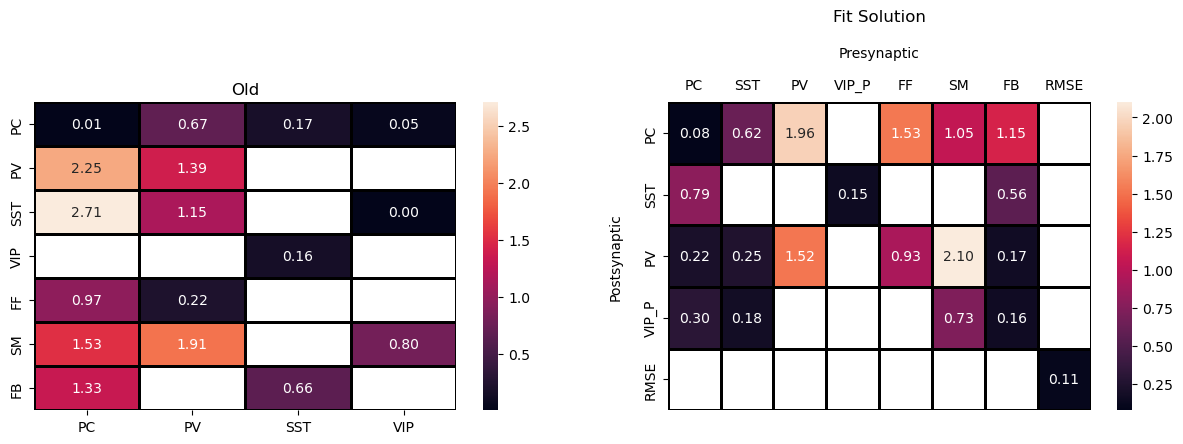

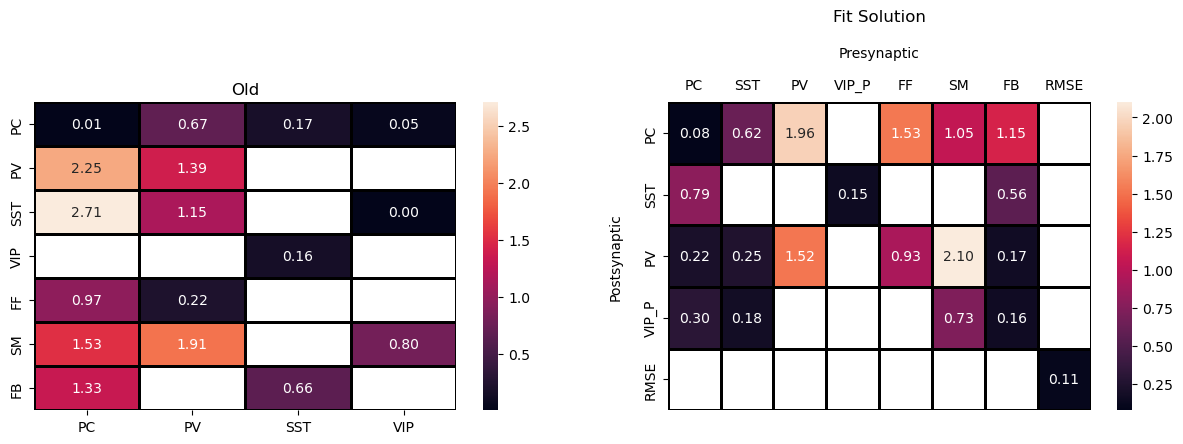

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sns.heatmap(heat, ax=ax[0], annot = True, linewidth = 1, linecolor = 'black', fmt=".2f")
sns.heatmap(heat_new_, ax=ax[1], annot = True, linewidth = 1, linecolor = 'black', fmt=".2f")
ax[0].set_title("Old")
ax[1].set_title("New")
ax[1].tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax[1].set(xlabel="\nPresynaptic\n", ylabel="\nPostsynaptic\n")
ax[1].title.set_text("Fit Solution")
ax[1].xaxis.set_label_position("top")
display.display(fig)

## L-BFGS-B

In [79]:
# count = 0

In [80]:
# %%time
# %matplotlib inline
# result_lbfgsb = minimize(residual_step, params, method='lbfgsb', args=(t_exp, init, data_pc_sen, data_pv, data_sst, data_vip), nan_policy='propagate', max_nfev=max_nfev/4, tol=1e-12)
# print()

In [81]:
# report_fit(result_lbfgsb)

In [82]:
# sim_lbfgsb = simulate_step(t_exp, init, params)
# fit_lbfgsb = simulate_step(t_exp, init, result_lbfgsb.params)
# # step = []

# # for i in t_exp:
# #     step.append(f_p(i, data_pv_exc))
    
# # curve = np.array(step) * result_lbfgsb.params['w_1'].value

# plt.figure(figsize=(10,5))
# plt.axis('auto')
# plt.plot(t_exp, pc_sen_new, color='black', marker='o', label='f_pc(t)')
# plt.plot(t_exp, fit_lbfgsb['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_lbfgsb['f_e'].values, color='red', label='init_fit')
# # plt.plot(t_exp, curve, color = (51/255, 255/255, 51/255), label='input')
# plt.title('PC_sen with "PV plasticity" + subpopulations', fontsize = 18)
# plt.legend(loc='upper left')
# plt.xlabel('time, s', fontsize=18)
# plt.ylabel('Firing rate, Hz', fontsize=18)
# plt.ylim(0, 0.6)
# plt.xticks(np.arange(0,21,1), size = 14)
# plt.yticks(size = 14)
# #plt.grid()

# # pars = (f"PC_sen:   {result_lbfgsb.params['w_0'].value:.6f} +/- {result_lbfgsb.params['w_0'].stderr:.6f}\n"
# #         f"PC_na:     {result_lbfgsb.params['w_1'].value:.6f} +/- {result_lbfgsb.params['w_1'].stderr:.6f}\n"
# #         f"PC_dep:   {result_lbfgsb.params['w_2'].value:.6f} +/- {result_lbfgsb.params['w_2'].stderr:.6f}\n"
# #         f"Input:      {result_lbfgsb.params['w_3'].value:.6f} +/- {result_lbfgsb.params['w_3'].stderr:.6f}\n"
# #         f"PV:           {result_lbfgsb.params['w_4'].value:.6f} +/- {result_lbfgsb.params['w_4'].stderr:.6f}\n"
# #         f"SST:         {result_lbfgsb.params['w_5'].value:.6f} +/- {result_lbfgsb.params['w_5'].stderr:.6f}\n"
# #         f"i_0:          {result_lbfgsb.params['i_0'].value:.6f} +/- {result_lbfgsb.params['i_0'].stderr:.6f}")

# # bbox = dict(boxstyle='round', fc='white', ec='orange', alpha=0.5)

# # plt.text(14.0, 0.050, pars, fontsize=12, bbox=bbox, horizontalalignment='right')

# plt.show()

## powell

In [83]:
count = 0

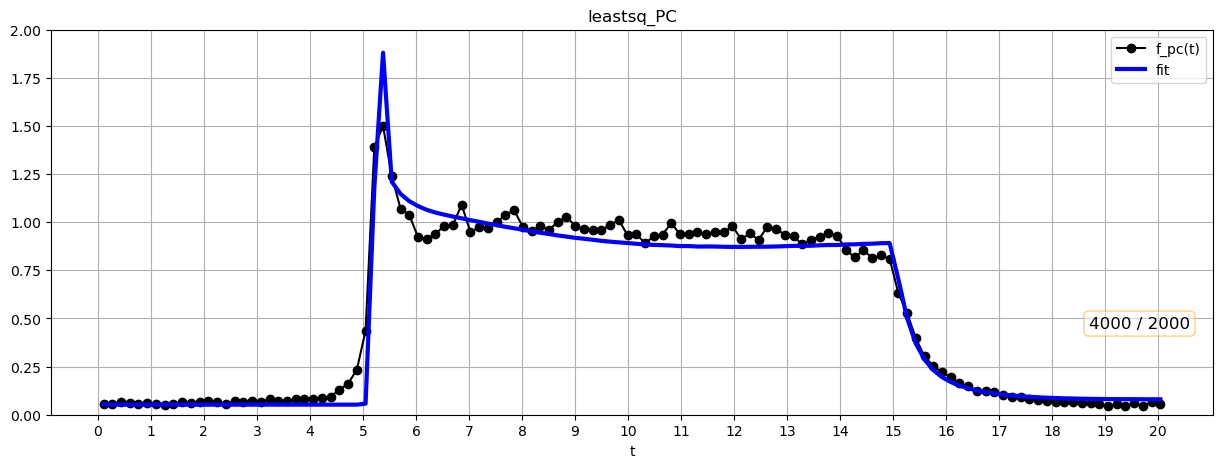


CPU times: total: 51min 16s
Wall time: 51min 55s


In [84]:
%%time
%matplotlib inline
result_powell = minimize(residual_step, params, method='powell', args=(t_exp, init, data_pc_all, data_pv, data_sst, data_vip), max_nfev = 2*max_nfev, nan_policy='propagate', tol=1e-14) #max_nfev = 4*max_nfev,
print()

In [85]:
report_fit(result_powell)

[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 4001
    # data points      = 488
    # variables        = 34
    chi-square         = 4160.96288
    reduced chi-square = 9.16511647
    Akaike info crit   = 1113.87495
    Bayesian info crit = 1256.34568
##  Warning: uncertainties could not be estimated:
    i_3:        at initial value
    delay_3:    at initial value
[[Variables]]
    w_0:        0.08036259 (init = 0.08281103)
    w_1:        1.51711222 (init = 1.5197)
    w_2:        1.06642237 (init = 1.06619)
    w_3:        1.95348618 (init = 1.955607)
    w_4:        0.62527863 (init = 0.631901)
    w_5:        0.21891909 (init = 0.2072392)
    w_6:        0.93397367 (init = 0.9263685)
    w_7:        2.09637082 (init = 2.111694)
    w_8:        1.51014470 (init = 1.510296)
    w_9:        0.25018781 (init = 0.2501333)
    w_10:       0.75694003 (init = 0.7837073)
    w_11:       0.55703987 (init = 0.5941593)
    w_12:       0.14718943 (init = 0.149970

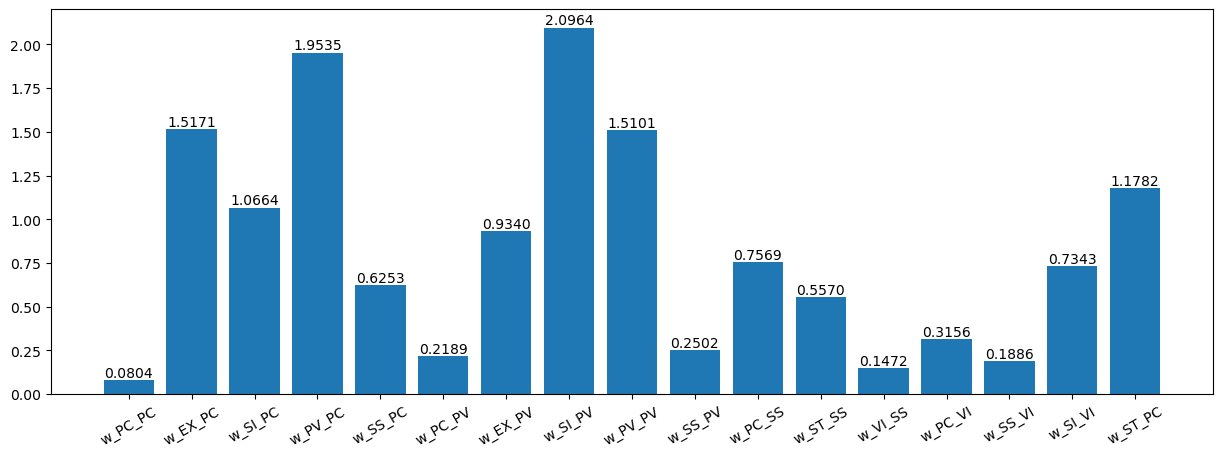

In [86]:
vals = []
for _, param in result_powell.params.items():
    vals.append(param.value)
    
plt.figure(figsize=(15,5))
plt.bar(range(len(vals[:17])),vals[:17], color='blue')
plt.xticks(range(len(vals[:17])), names[:17], rotation = 30)
plt.bar_label(plt.bar(range(len(vals[:17])),vals[:17]), fmt = '{:.4f}')
plt.show()

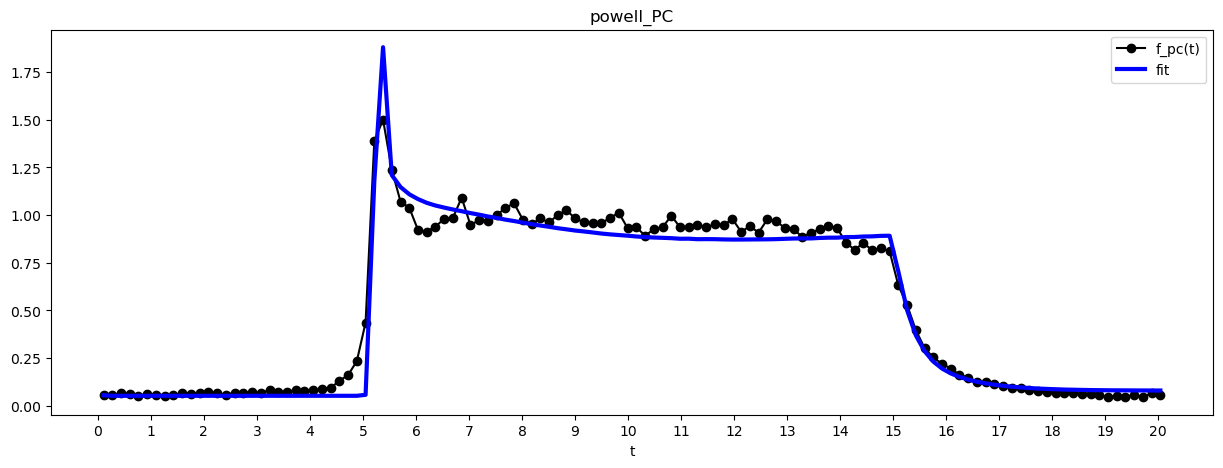

In [87]:
sim_powell = simulate_step(t_exp, init, params)
fit_powell = simulate_step(t_exp, init, result_powell.params)
# step = []

# for i in t_exp:
#     step.append(f_p(i, data_pv_exc))
    
# curve = np.array(step) * result_powell.params['w_1'].value

plt.figure(figsize=(15,5))
plt.plot(t_exp, pc_all_new, color='black', marker='o', label='f_pc(t)')
plt.plot(t_exp, fit_powell['f_e'].values, color='blue', label='fit', linewidth=3)
# plt.plot(t_exp, sim_powell['f_e'].values, color='red', label='init_fit')
# plt.plot(t_exp, curve, color = 'green', label='input')
plt.title('powell_PC')
plt.legend(loc='best')
plt.xlabel('t')
#plt.ylim(-0.1, 0.6)
plt.xticks(np.arange(0,21,1))
#plt.grid()
plt.show()

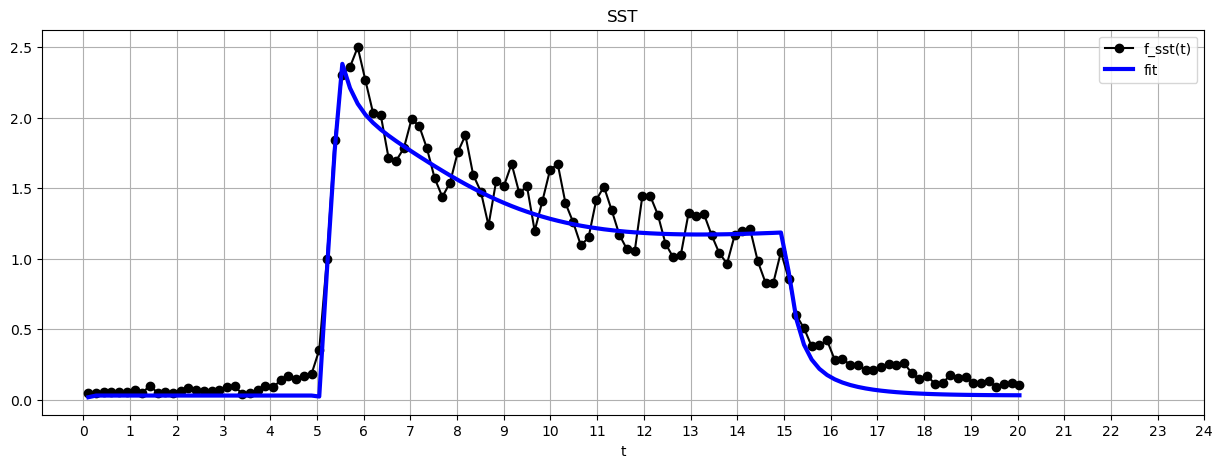

In [88]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_sst, color='black', marker='o', label='f_sst(t)')
plt.plot(t_exp, fit_powell['f_sst'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_powell['f_sst'].values, color='red', label='init_fit')
plt.title('SST')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

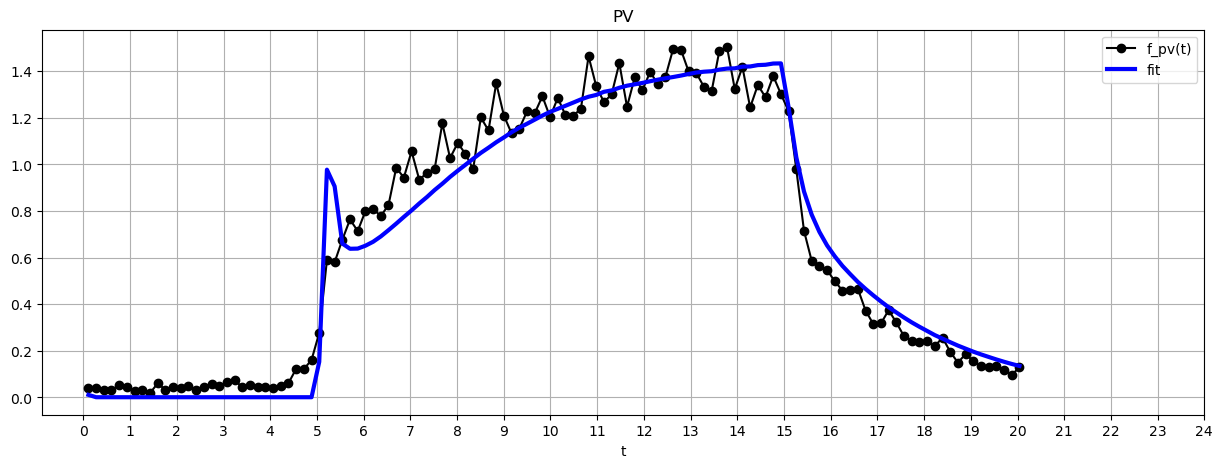

In [89]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_pv, color='black', marker='o', label='f_pv(t)')
plt.plot(t_exp, fit_powell['f_pv'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_pv'].values, color='red', label='init_fit')
plt.title('PV')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()

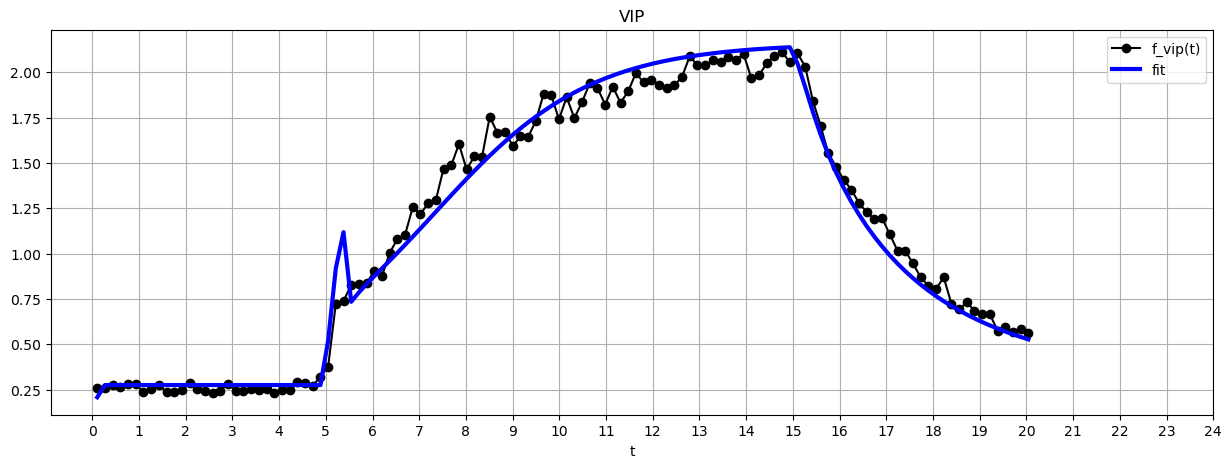

In [90]:
plt.figure(figsize=(15,5))
plt.plot(t_exp, data_vip, color='black', marker='o', label='f_vip(t)')
plt.plot(t_exp, fit_powell['f_vip'].values, color='blue', label='fit', linewidth=3)
#plt.plot(t_exp, sim_nelder['f_vip'].values, color='red', label='init_fit')
plt.title('VIP')
plt.legend(loc='best')
plt.xlabel('t')
plt.xlim()
plt.xticks(np.arange(0,25,1))
plt.grid()
plt.show()